# Big Data Proj: Subzero Signals: Analyzing Icecube Neutrinos

Group Members:
1. Rohaan Advani - rna3535
2. Meghna Savit - ms14622
3. Chinmayan Pradeep - cpk286
4. Shrish Singhal - sks9405

# Install and Import Necessary Libraries:

In [59]:
!pip install pyspark
!pip install faiss-cpu
!pip install pycaret

In [60]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.types import DoubleType
import faiss
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px
import pyarrow.parquet as pq
from tqdm import tqdm
import shutil
import time
import glob
import polars as pl

# PART 1. Data Exploration and Feature Engineering:

## 1A: Read and Analyze Schema / Distribution of Batch and Metadata:

In [3]:
ts, tp = 0, 0

start = time.time()
spark = SparkSession.builder.appName("Icecube - Neutrino").getOrCreate()
b1_df_spark = spark.read.parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_1.parquet')
b1_df_spark.printSchema()
b1_df_spark.describe("time", "charge").show()
print("Number of pulses:", b1_df_spark.count())
ts += time.time() - start
b1_df_spark.show(10)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/09 15:01:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- sensor_id: short (nullable = true)
 |-- time: long (nullable = true)
 |-- charge: double (nullable = true)
 |-- auxiliary: boolean (nullable = true)
 |-- event_id: long (nullable = true)



+-------+------------------+-------------------+
|summary|              time|             charge|
+-------+------------------+-------------------+
|  count|          32792416|           32792416|
|   mean|13130.478158425412|  3.908981116823328|
| stddev| 4876.796560647113| 16.288969314122628|
|    min|              5714|0.02500000037252903|
|    max|             77785|   2762.02490234375|
+-------+------------------+-------------------+

Number of pulses: 32792416


+---------+----+-------------------+---------+--------+
|sensor_id|time|             charge|auxiliary|event_id|
+---------+----+-------------------+---------+--------+
|     3918|5928| 1.3250000476837158|     true|      24|
|     4157|6115| 1.1749999523162842|     true|      24|
|     3520|6492|  0.925000011920929|     true|      24|
|     5041|6665|0.22499999403953552|     true|      24|
|     2948|8054| 1.5750000476837158|     true|      24|
|      860|8124|  0.675000011920929|     true|      24|
|     2440|8284|              1.625|     true|      24|
|     1743|8478| 0.7749999761581421|     true|      24|
|     3609|8572|  1.024999976158142|     true|      24|
|     5057|8680| 3.9749999046325684|     true|      24|
+---------+----+-------------------+---------+--------+
only showing top 10 rows



Compare spark with polars

In [4]:
start = time.time()
b1_df_polars = pl.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_1.parquet')
print(b1_df_polars.schema)
print(b1_df_polars.describe())
print("Number of pulses:", len(b1_df_polars))
tp += time.time() - start
b1_df_polars.head(10)

OrderedDict([('sensor_id', Int16), ('time', Int64), ('charge', Float64), ('auxiliary', Boolean), ('event_id', Int64)])
shape: (9, 6)
┌────────────┬─────────────┬──────────────┬─────────────┬─────────────┬───────────────┐
│ statistic  ┆ sensor_id   ┆ time         ┆ charge      ┆ auxiliary   ┆ event_id      │
│ ---        ┆ ---         ┆ ---          ┆ ---         ┆ ---         ┆ ---           │
│ str        ┆ f64         ┆ f64          ┆ f64         ┆ f64         ┆ f64           │
╞════════════╪═════════════╪══════════════╪═════════════╪═════════════╪═══════════════╡
│ count      ┆ 3.2792416e7 ┆ 3.2792416e7  ┆ 3.2792416e7 ┆ 3.2792416e7 ┆ 3.2792416e7   │
│ null_count ┆ 0.0         ┆ 0.0          ┆ 0.0         ┆ 0.0         ┆ 0.0           │
│ mean       ┆ 2713.044953 ┆ 13130.478158 ┆ 3.908981    ┆ 0.281788    ┆ 1.6642e6      │
│ std        ┆ 1543.415901 ┆ 4876.796561  ┆ 16.288969   ┆ null        ┆ 946800.102388 │
│ min        ┆ 0.0         ┆ 5714.0       ┆ 0.025       ┆ 0.0         ┆ 24.

sensor_id,time,charge,auxiliary,event_id
i16,i64,f64,bool,i64
3918,5928,1.325,true,24
4157,6115,1.175,true,24
3520,6492,0.925,true,24
5041,6665,0.225,true,24
2948,8054,1.575,true,24
860,8124,0.675,true,24
2440,8284,1.625,true,24
1743,8478,0.775,true,24
3609,8572,1.025,true,24


In [5]:
start = time.time()
train_meta = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet')
filtered_df = train_meta[(train_meta['batch_id'] == 1)].reset_index(drop=True)
filtered_df = spark.createDataFrame(filtered_df)
filtered_df.printSchema()
filtered_df.describe("azimuth", "zenith").show()
print("Number of events in batch:", filtered_df.count())
ts += time.time() - start
print('Spark Execution Time for Initilization: '+str(ts)+' seconds')
filtered_df.show(10)

root
 |-- batch_id: long (nullable = true)
 |-- event_id: long (nullable = true)
 |-- first_pulse_index: long (nullable = true)
 |-- last_pulse_index: long (nullable = true)
 |-- azimuth: double (nullable = true)
 |-- zenith: double (nullable = true)



24/05/09 15:03:04 WARN TaskSetManager: Stage 9 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 15:03:07 WARN TaskSetManager: Stage 12 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+--------------------+
|summary|             azimuth|              zenith|
+-------+--------------------+--------------------+
|  count|              200000|              200000|
|   mean|  3.1418665231786798|  1.5335901966043297|
| stddev|   1.812990260432623|  0.6901477245207965|
|    min|3.963045076734735...|0.005914516818854429|
|    max|   6.283163100083143|  3.1328398777962825|
+-------+--------------------+--------------------+



Number of events in batch: 200000
Spark Execution Time for Initilization: 101.8334686756134 seconds


24/05/09 15:03:08 WARN TaskSetManager: Stage 15 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------+-----------------+----------------+--------------------+------------------+
|batch_id|event_id|first_pulse_index|last_pulse_index|             azimuth|            zenith|
+--------+--------+-----------------+----------------+--------------------+------------------+
|       1|      24|                0|              60|   5.029554633390068|2.0874975005610428|
|       1|      41|               61|             111|  0.4177421750383681|1.5496862936709712|
|       1|      59|              112|             147|  1.1604659135604434| 2.401942407585757|
|       1|      67|              148|             289|   5.845951997240071|0.7590535704990591|
|       1|      72|              290|             351|  0.6537188048693313|0.9391172295951236|
|       1|      77|              352|             401|0.011371512389135186| 1.295370753782866|
|       1|      79|              402|             717|  3.5333968141714607| 2.479946556392892|
|       1|      82|              718|             

In [6]:
start = time.time()
train_meta_pl = pl.from_pandas(pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet'))
filtered_df_pl = train_meta_pl.filter(pl.col('batch_id') == 1)
print(filtered_df_pl.schema)
print(filtered_df_pl.describe())
print("Number of events in batch:", len(filtered_df_pl))
tp += time.time() - start
print('Polars Execution Time for Initilization: '+str(tp)+' seconds')
filtered_df_pl.head(10)

OrderedDict([('batch_id', Int64), ('event_id', Int64), ('first_pulse_index', Int64), ('last_pulse_index', Int64), ('azimuth', Float64), ('zenith', Float64)])
shape: (9, 7)
┌────────────┬──────────┬───────────────┬──────────────────┬─────────────────┬──────────┬──────────┐
│ statistic  ┆ batch_id ┆ event_id      ┆ first_pulse_inde ┆ last_pulse_inde ┆ azimuth  ┆ zenith   │
│ ---        ┆ ---      ┆ ---           ┆ x                ┆ x               ┆ ---      ┆ ---      │
│ str        ┆ f64      ┆ f64           ┆ ---              ┆ ---             ┆ f64      ┆ f64      │
│            ┆          ┆               ┆ f64              ┆ f64             ┆          ┆          │
╞════════════╪══════════╪═══════════════╪══════════════════╪═════════════════╪══════════╪══════════╡
│ count      ┆ 200000.0 ┆ 200000.0      ┆ 200000.0         ┆ 200000.0        ┆ 200000.0 ┆ 200000.0 │
│ null_count ┆ 0.0      ┆ 0.0           ┆ 0.0              ┆ 0.0             ┆ 0.0      ┆ 0.0      │
│ mean       ┆ 1.0  

batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
i64,i64,i64,i64,f64,f64
1,24,0,60,5.029555,2.087498
1,41,61,111,0.417742,1.549686
1,59,112,147,1.160466,2.401942
1,67,148,289,5.845952,0.759054
1,72,290,351,0.653719,0.939117
1,77,352,401,0.011372,1.295371
1,79,402,717,3.533397,2.479947
1,82,718,762,5.252108,0.672366
1,121,763,803,3.084929,2.06588


## 1B: Find Number of Pulses, Unique Pulses and Uniqueness Percentage:

In the context of our dataset, one pulse refers to one event being detected by one sensor.

In [7]:
filtered_df = filtered_df.withColumn("n_pulses", col("last_pulse_index") - col("first_pulse_index"))
filtered_df.limit(10).toPandas()

24/05/09 15:03:53 WARN TaskSetManager: Stage 16 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.


,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith,n_pulses
0,1,24,0,60,5.029555,2.087498,60
1,1,41,61,111,0.417742,1.549686,50
2,1,59,112,147,1.160466,2.401942,35
3,1,67,148,289,5.845952,0.759054,141
4,1,72,290,351,0.653719,0.939117,61
5,1,77,352,401,0.011372,1.295371,49
6,1,79,402,717,3.533397,2.479947,315
7,1,82,718,762,5.252108,0.672366,44
8,1,121,763,803,3.084929,2.065880,40
9,1,127,804,846,6.154335,1.371721,42


In [8]:
unique_sensors_per_event = b1_df_spark.groupBy("event_id").agg(countDistinct("sensor_id").alias("n_unique_pulses"))
unique_sensors_per_event.show(10)

24/05/09 15:03:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:04:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:04:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:04:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:04:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:04:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:04:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:04:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:04:24 WARN RowBasedKeyValueBatch: Calling spill() on

+--------+---------------+
|event_id|n_unique_pulses|
+--------+---------------+
|   10959|            103|
|   13460|             37|
|   76901|             62|
|   77947|             73|
|  111537|             31|
|  114346|            105|
|  123425|             45|
|  133904|            215|
|  141552|             92|
|  147907|             46|
+--------+---------------+
only showing top 10 rows



In [9]:
filtered_df = filtered_df.join(unique_sensors_per_event, "event_id", "left_outer")
filtered_df.limit(10).toPandas()

24/05/09 15:04:34 WARN TaskSetManager: Stage 23 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 15:04:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:04:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:05:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:05:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:05:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:05:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:05:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:05:02 WARN RowBasedKeyValue

,event_id,batch_id,first_pulse_index,last_pulse_index,azimuth,zenith,n_pulses,n_unique_pulses
0,72,1,290,351,0.653719,0.939117,61,48
1,77,1,352,401,0.011372,1.295371,49,41
2,817407,1,7957019,7957057,0.116425,1.963650,38,28
3,817428,1,7957058,7957112,5.151476,1.613200,54,48
4,817459,1,7957113,7957160,2.223192,0.307956,47,35
5,817518,1,7957465,7957503,3.464272,2.842681,38,31
6,817531,1,7957504,7957554,6.014309,0.172523,50,46
7,1634608,1,16062504,16062589,2.741471,1.279581,85,51
8,1634626,1,16062628,16062707,3.291211,2.724062,79,60
9,1634786,1,16062880,16062926,3.300050,1.795205,46,38


In [10]:
filtered_df = filtered_df.withColumn("unique%", 100 * col("n_unique_pulses") / (col("n_pulses")))
filtered_df.limit(10).toPandas()

24/05/09 15:05:11 WARN TaskSetManager: Stage 31 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 15:05:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:05:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:05:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:05:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:05:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:05:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:05:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:05:38 WARN RowBasedKeyValue

,event_id,batch_id,first_pulse_index,last_pulse_index,azimuth,zenith,n_pulses,n_unique_pulses,unique%
0,72,1,290,351,0.653719,0.939117,61,48,44.036697
1,77,1,352,401,0.011372,1.295371,49,41,45.555556
2,817407,1,7957019,7957057,0.116425,1.963650,38,28,42.424242
3,817428,1,7957058,7957112,5.151476,1.613200,54,48,47.058824
4,817459,1,7957113,7957160,2.223192,0.307956,47,35,42.682927
5,817518,1,7957465,7957503,3.464272,2.842681,38,31,44.927536
6,817531,1,7957504,7957554,6.014309,0.172523,50,46,47.916667
7,1634608,1,16062504,16062589,2.741471,1.279581,85,51,37.500000
8,1634626,1,16062628,16062707,3.291211,2.724062,79,60,43.165468
9,1634786,1,16062880,16062926,3.300050,1.795205,46,38,45.238095


## 1C: Evaluate Time Statistics of Batch Data and Join to Metadata:

Here time is in Nanoseconds and is relative in nature.

In [11]:
time_stats_per_event = b1_df_spark.groupBy("event_id").agg(min("time").alias("min_time"),
                                    max("time").alias("max_time"),
                                    avg("time").alias("avg_time"))
time_stats_per_event.show(10)

+--------+--------+--------+------------------+
|event_id|min_time|max_time|          avg_time|
+--------+--------+--------+------------------+
|    5409|    5948|   19046|12049.852459016394|
|   10959|    5994|   19435|11692.900621118013|
|   13460|    6049|   16518|10457.511111111111|
|   25084|    6135|   17049|10662.625531914893|
|   32098|    6257|   16694|10611.333333333334|
|   38543|    6373|   19209|12601.873786407767|
|   39713|    5911|   18595|12023.051724137931|
|   41424|    6145|   15662|10847.217391304348|
|   44342|    6972|   15813| 12151.52380952381|
|   56964|    6150|   30115|16877.886597938144|
+--------+--------+--------+------------------+
only showing top 10 rows



In [12]:
filtered_df = filtered_df.join(time_stats_per_event, "event_id", "left_outer")
filtered_df.limit(10).toPandas()

24/05/09 15:05:51 WARN TaskSetManager: Stage 42 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 15:05:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:05:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:06:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:06:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:06:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:06:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:06:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:06:20 WARN RowBasedKeyValue

,event_id,batch_id,first_pulse_index,last_pulse_index,azimuth,zenith,n_pulses,n_unique_pulses,unique%,min_time,max_time,avg_time
0,72,1,290,351,0.653719,0.939117,61,48,44.036697,6083,17654,11433.064516
1,77,1,352,401,0.011372,1.295371,49,41,45.555556,5976,16100,10821.660000
2,817407,1,7957019,7957057,0.116425,1.963650,38,28,42.424242,6069,16271,11000.743590
3,817428,1,7957058,7957112,5.151476,1.613200,54,48,47.058824,6576,16605,10994.545455
4,817459,1,7957113,7957160,2.223192,0.307956,47,35,42.682927,5902,16625,11103.625000
5,817518,1,7957465,7957503,3.464272,2.842681,38,31,44.927536,6677,16007,10985.487179
6,817531,1,7957504,7957554,6.014309,0.172523,50,46,47.916667,5924,17067,11066.921569
7,1634608,1,16062504,16062589,2.741471,1.279581,85,51,37.500000,7119,22774,12443.953488
8,1634626,1,16062628,16062707,3.291211,2.724062,79,60,43.165468,5904,19009,11853.225000
9,1634786,1,16062880,16062926,3.300050,1.795205,46,38,45.238095,6008,17006,10821.042553


## 1D: Evaluate Charge Statistics of Batch Data and Join to Metadata:

An estimate of the amount of light in the pulse, in units of photoelectrons (p.e.).

In [13]:
charge_stats_per_event = b1_df_spark.groupBy("event_id").agg(min("charge").alias("min_charge"),
                                    max("charge").alias("max_charge"),
                                    avg("charge").alias("avg_charge"))
charge_stats_per_event.show(10)

+--------+-------------------+------------------+------------------+
|event_id|         min_charge|        max_charge|        avg_charge|
+--------+-------------------+------------------+------------------+
|    5409|0.22499999403953552|2.2249999046325684|0.9086065517097223|
|   10959|              0.125|             2.375|0.9215838508391232|
|   13460| 0.2750000059604645|3.0250000953674316|0.8750000033113692|
|   25084|              0.125|3.4749999046325684|0.9296808498971005|
|   32098|0.17499999701976776| 5.574999809265137|0.9811403517398918|
|   38543| 0.2750000059604645|2.0250000953674316|0.8842233008551366|
|   39713|0.22499999403953552|2.7750000953674316|0.8801724206784676|
|   41424|0.32499998807907104|             1.875|0.9782608695652174|
|   44342| 0.2750000059604645|2.7249999046325684|1.0047619002205985|
|   56964|0.17499999701976776|12.475000381469727|  1.09639175144053|
+--------+-------------------+------------------+------------------+
only showing top 10 rows



In [14]:
filtered_df = filtered_df.join(charge_stats_per_event, "event_id", "left_outer")
filtered_df.limit(10).toPandas()

24/05/09 15:06:34 WARN TaskSetManager: Stage 56 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 15:06:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:06:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:06:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:06:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:06:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:07:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:07:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:07:07 WARN RowBasedKeyValue

,event_id,batch_id,first_pulse_index,last_pulse_index,azimuth,zenith,n_pulses,n_unique_pulses,unique%,min_time,max_time,avg_time,min_charge,max_charge,avg_charge
0,72,1,290,351,0.653719,0.939117,61,48,44.036697,6083,17654,11433.064516,0.125,1.675,0.899194
1,77,1,352,401,0.011372,1.295371,49,41,45.555556,5976,16100,10821.660000,0.175,5.875,1.097000
2,817407,1,7957019,7957057,0.116425,1.963650,38,28,42.424242,6069,16271,11000.743590,0.225,3.925,0.966026
3,817428,1,7957058,7957112,5.151476,1.613200,54,48,47.058824,6576,16605,10994.545455,0.225,2.475,0.974091
4,817459,1,7957113,7957160,2.223192,0.307956,47,35,42.682927,5902,16625,11103.625000,0.225,3.075,0.942708
5,817518,1,7957465,7957503,3.464272,2.842681,38,31,44.927536,6677,16007,10985.487179,0.275,2.925,0.998077
6,817531,1,7957504,7957554,6.014309,0.172523,50,46,47.916667,5924,17067,11066.921569,0.225,1.425,0.892647
7,1634608,1,16062504,16062589,2.741471,1.279581,85,51,37.500000,7119,22774,12443.953488,0.225,9.775,1.177907
8,1634626,1,16062628,16062707,3.291211,2.724062,79,60,43.165468,5904,19009,11853.225000,0.175,4.775,0.981875
9,1634786,1,16062880,16062926,3.300050,1.795205,46,38,45.238095,6008,17006,10821.042553,0.225,2.325,1.007979


## 1E: What Percentage of each event's data is digitized?

If True, the pulse was not fully digitized, is of lower quality, and was more likely to originate from noise. If False, then this pulse was contributed to the trigger decision and the pulse was fully digitized.

In [15]:
auxiliary_counts_per_event = b1_df_spark.groupBy("event_id").pivot("auxiliary").agg(count(expr("*")))
auxiliary_counts_per_event.show(10)

+--------+-----+----+
|event_id|false|true|
+--------+-----+----+
|   41424|   12|  34|
|  126476|    7|  29|
|  771897|   25|  80|
| 1526995|    4|  38|
| 2169372|   26|  74|
| 2789235|   28|  61|
| 3104850|   45|  31|
|  203611|   12|  20|
|  571166|   34|  58|
| 1432838| 1137|  55|
+--------+-----+----+
only showing top 10 rows



In [16]:
filtered_df = filtered_df.join(auxiliary_counts_per_event, "event_id", "left_outer")
filtered_df.limit(10).toPandas()

24/05/09 15:07:22 WARN TaskSetManager: Stage 84 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 15:07:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:07:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:07:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:07:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:07:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:07:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:07:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:07:45 WARN RowBasedKeyValue

,event_id,batch_id,first_pulse_index,last_pulse_index,azimuth,zenith,n_pulses,n_unique_pulses,unique%,min_time,max_time,avg_time,min_charge,max_charge,avg_charge,false,true
0,72,1,290,351,0.653719,0.939117,61,48,44.036697,6083,17654,11433.064516,0.125,1.675,0.899194,20,42
1,77,1,352,401,0.011372,1.295371,49,41,45.555556,5976,16100,10821.660000,0.175,5.875,1.097000,9,41
2,817407,1,7957019,7957057,0.116425,1.963650,38,28,42.424242,6069,16271,11000.743590,0.225,3.925,0.966026,12,27
3,817428,1,7957058,7957112,5.151476,1.613200,54,48,47.058824,6576,16605,10994.545455,0.225,2.475,0.974091,10,45
4,817459,1,7957113,7957160,2.223192,0.307956,47,35,42.682927,5902,16625,11103.625000,0.225,3.075,0.942708,15,33
5,817518,1,7957465,7957503,3.464272,2.842681,38,31,44.927536,6677,16007,10985.487179,0.275,2.925,0.998077,8,31
6,817531,1,7957504,7957554,6.014309,0.172523,50,46,47.916667,5924,17067,11066.921569,0.225,1.425,0.892647,10,41
7,1634608,1,16062504,16062589,2.741471,1.279581,85,51,37.500000,7119,22774,12443.953488,0.225,9.775,1.177907,48,38
8,1634626,1,16062628,16062707,3.291211,2.724062,79,60,43.165468,5904,19009,11853.225000,0.175,4.775,0.981875,41,39
9,1634786,1,16062880,16062926,3.300050,1.795205,46,38,45.238095,6008,17006,10821.042553,0.225,2.325,1.007979,11,36


In [17]:
filtered_df = filtered_df.withColumn("dig%", 100 * col("false") / (col("false") + col("true")))
filtered_df.limit(10).toPandas()

24/05/09 15:08:17 WARN TaskSetManager: Stage 103 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 15:08:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:08:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:08:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:08:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:08:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:08:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:08:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:08:28 WARN RowBasedKeyValu

,event_id,batch_id,first_pulse_index,last_pulse_index,azimuth,zenith,n_pulses,n_unique_pulses,unique%,min_time,max_time,avg_time,min_charge,max_charge,avg_charge,false,true,dig%
0,72,1,290,351,0.653719,0.939117,61,48,44.036697,6083,17654,11433.064516,0.125,1.675,0.899194,20,42,32.258065
1,77,1,352,401,0.011372,1.295371,49,41,45.555556,5976,16100,10821.660000,0.175,5.875,1.097000,9,41,18.000000
2,817407,1,7957019,7957057,0.116425,1.963650,38,28,42.424242,6069,16271,11000.743590,0.225,3.925,0.966026,12,27,30.769231
3,817428,1,7957058,7957112,5.151476,1.613200,54,48,47.058824,6576,16605,10994.545455,0.225,2.475,0.974091,10,45,18.181818
4,817459,1,7957113,7957160,2.223192,0.307956,47,35,42.682927,5902,16625,11103.625000,0.225,3.075,0.942708,15,33,31.250000
5,817518,1,7957465,7957503,3.464272,2.842681,38,31,44.927536,6677,16007,10985.487179,0.275,2.925,0.998077,8,31,20.512821
6,817531,1,7957504,7957554,6.014309,0.172523,50,46,47.916667,5924,17067,11066.921569,0.225,1.425,0.892647,10,41,19.607843
7,1634608,1,16062504,16062589,2.741471,1.279581,85,51,37.500000,7119,22774,12443.953488,0.225,9.775,1.177907,48,38,55.813953
8,1634626,1,16062628,16062707,3.291211,2.724062,79,60,43.165468,5904,19009,11853.225000,0.175,4.775,0.981875,41,39,51.250000
9,1634786,1,16062880,16062926,3.300050,1.795205,46,38,45.238095,6008,17006,10821.042553,0.225,2.325,1.007979,11,36,23.404255


## 1F: Use Window Functions over time and charge data:

In [18]:
window_spec = Window.partitionBy("event_id").orderBy("time")
numbered_df = b1_df_spark.withColumn("row_number", row_number().over(window_spec))
numbered_df.show()

+---------+----+-------------------+---------+--------+----------+
|sensor_id|time|             charge|auxiliary|event_id|row_number|
+---------+----+-------------------+---------+--------+----------+
|     3196|5976|  0.824999988079071|     true|      77|         1|
|      724|6537| 1.0750000476837158|     true|      77|         2|
|     4967|6648|              0.375|     true|      77|         3|
|     1165|6687|  0.675000011920929|     true|      77|         4|
|     4974|6901|              0.375|     true|      77|         5|
|     1618|7754| 0.7250000238418579|     true|      77|         6|
|     3384|8161|0.17499999701976776|     true|      77|         7|
|      447|8304| 1.0750000476837158|     true|      77|         8|
|     4815|8444| 0.4749999940395355|     true|      77|         9|
|      633|8515|  1.225000023841858|     true|      77|        10|
|     2726|8900|              1.125|     true|      77|        11|
|     2393|8980|  1.225000023841858|     true|      77|       

In [19]:
rank_window = Window.partitionBy("event_id").orderBy(col("charge").desc())
ranked_df = b1_df_spark.withColumn("rank", rank().over(rank_window))
ranked_df.show()

+---------+-----+------------------+---------+--------+----+
|sensor_id| time|            charge|auxiliary|event_id|rank|
+---------+-----+------------------+---------+--------+----+
|     5069|15749|             5.875|     true|      77|   1|
|     3357|11527|3.4749999046325684|     true|      77|   2|
|     4275|15302|2.4749999046325684|     true|      77|   3|
|     4275|15308| 2.075000047683716|     true|      77|   4|
|     3725| 9876|2.0250000953674316|    false|      77|   5|
|     1690|13965|1.6749999523162842|     true|      77|   6|
|     3670|10406|             1.375|     true|      77|   7|
|     2089|12004|             1.375|     true|      77|   7|
|      977|12571| 1.274999976158142|     true|      77|   9|
|      633| 8515| 1.225000023841858|     true|      77|  10|
|     2393| 8980| 1.225000023841858|     true|      77|  10|
|     3301|10305| 1.225000023841858|     true|      77|  10|
|       60|12088| 1.225000023841858|     true|      77|  10|
|     2327|12364| 1.2250

## 1G: Read and Analyze Schema / Distribution of Sensor data:

In [20]:
sen = spark.read.option("inferSchema", "true").option("header", "true").csv('/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')
sen.printSchema()
sen.describe("x", "y", "z").show()
sen.limit(10).toPandas()

root
 |-- sensor_id: integer (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)

+-------+------------------+------------------+-------------------+
|summary|                 x|                 y|                  z|
+-------+------------------+------------------+-------------------+
|  count|              5160|              5160|               5160|
|   mean| 5.870829457364252|-2.518608527134853|-23.905765503875962|
| stddev|285.15121290877863|269.40972915125235| 296.45656250122653|
|    min|            -570.9|           -521.08|            -512.82|
|    max|            576.37|             509.5|             524.56|
+-------+------------------+------------------+-------------------+



,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95
5,5,-256.14,-521.08,410.93
6,6,-256.14,-521.08,393.91
7,7,-256.14,-521.08,376.88
8,8,-256.14,-521.08,359.86
9,9,-256.14,-521.08,342.84


## 1H: Calculate Azimuth and Zenith of Sensors and combine data to Batch:

In [21]:
azimuthZenithDF = sen.withColumn("azimuth", atan2(col("y"), col("x"))).withColumn("zenith", atan2(sqrt(col("x")*col("x") + col("y")*col("y")), col("z")))
azimuthZenithDF.show()

+---------+-------+-------+------+------------------+------------------+
|sensor_id|      x|      y|     z|           azimuth|            zenith|
+---------+-------+-------+------+------------------+------------------+
|        0|-256.14|-521.08|496.03|-2.027665945162675|0.8638140179465404|
|        1|-256.14|-521.08|479.01|-2.027665945162675|0.8810069064619077|
|        2|-256.14|-521.08|461.99|-2.027665945162675|0.8987017039347429|
|        3|-256.14|-521.08|444.97|-2.027665945162675|0.9169091387753181|
|        4|-256.14|-521.08|427.95|-2.027665945162675|0.9356392098513763|
|        5|-256.14|-521.08|410.93|-2.027665945162675|0.9549010309757671|
|        6|-256.14|-521.08|393.91|-2.027665945162675|0.9747026620776355|
|        7|-256.14|-521.08|376.88|-2.027665945162675|0.9950630449511219|
|        8|-256.14|-521.08|359.86|-2.027665945162675|1.0159636663307139|
|        9|-256.14|-521.08|342.84|-2.027665945162675|1.0374200831965144|
|       10|-256.14|-521.08|325.82|-2.02766594516267

In [22]:
b1_df_spark = b1_df_spark.join(sen, "sensor_id", "left_outer")
b1_df_spark.limit(10).toPandas()

,sensor_id,time,charge,auxiliary,event_id,x,y,z
0,3918,5928,1.325,True,24,303.41,335.64,206.58
1,4157,6115,1.175,True,24,-145.45,374.24,212.73
2,3520,6492,0.925,True,24,505.27,257.88,-174.60
3,5041,6665,0.225,True,24,-9.68,-79.50,181.00
4,2948,8054,1.575,True,24,576.37,170.92,357.88
5,860,8124,0.675,True,24,-290.66,-307.38,163.61
6,2440,8284,1.625,True,24,-526.63,-15.60,-178.17
7,1743,8478,0.775,True,24,500.43,-58.45,450.79
8,3609,8572,1.025,True,24,-313.60,237.44,348.01
9,5057,8680,3.975,True,24,-9.68,-79.50,-205.47


## 1I: Calculate Coordinates of Events using Angles:

In [23]:
filtered_df = filtered_df.withColumn("x", cos(col("azimuth")) * sin(col("zenith")))
filtered_df = filtered_df.withColumn("y", sin(col("azimuth")) * sin(col("zenith")))
filtered_df = filtered_df.withColumn("z", cos(col("zenith")))
filtered_df.limit(10).toPandas()

24/05/09 15:09:42 WARN TaskSetManager: Stage 138 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 15:09:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:09:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:09:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:09:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:09:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:09:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:09:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:09:56 WARN RowBasedKeyValu

,event_id,batch_id,first_pulse_index,last_pulse_index,azimuth,zenith,n_pulses,n_unique_pulses,unique%,min_time,...,avg_time,min_charge,max_charge,avg_charge,false,true,dig%,x,y,z
0,72,1,290,351,0.653719,0.939117,61,48,44.036697,6083,...,11433.064516,0.125,1.675,0.899194,20,42,32.258065,0.640648,0.490794,0.590501
1,77,1,352,401,0.011372,1.295371,49,41,45.555556,5976,...,10821.660000,0.175,5.875,1.097000,9,41,18.000000,0.962247,0.010943,0.271956
2,817407,1,7957019,7957057,0.116425,1.963650,38,28,42.424242,6069,...,11000.743590,0.225,3.925,0.966026,12,27,30.769231,0.917566,0.107313,-0.382826
3,817428,1,7957058,7957112,5.151476,1.613200,54,48,47.058824,6576,...,10994.545455,0.225,2.475,0.974091,10,45,18.181818,0.424731,-0.904327,-0.042391
4,817459,1,7957113,7957160,2.223192,0.307956,47,35,42.682927,5902,...,11103.625000,0.225,3.075,0.942708,15,33,31.250000,-0.184017,0.240862,0.952955
5,817518,1,7957465,7957503,3.464272,2.842681,38,31,44.927536,6677,...,10985.487179,0.275,2.925,0.998077,8,31,20.512821,-0.279282,-0.093382,-0.955657
6,817531,1,7957504,7957554,6.014309,0.172523,50,46,47.916667,5924,...,11066.921569,0.225,1.425,0.892647,10,41,19.607843,0.165500,-0.045603,0.985155
7,1634608,1,16062504,16062589,2.741471,1.279581,85,51,37.500000,7119,...,12443.953488,0.225,9.775,1.177907,48,38,55.813953,-0.882235,0.373129,0.287116
8,1634626,1,16062628,16062707,3.291211,2.724062,79,60,43.165468,5904,...,11853.225000,0.175,4.775,0.981875,41,39,51.250000,-0.400974,-0.060445,-0.914093
9,1634786,1,16062880,16062926,3.300050,1.795205,46,38,45.238095,6008,...,10821.042553,0.225,2.325,1.007979,11,36,23.404255,-0.962712,-0.153838,-0.222530


## 1J: Batch Exploration Function as per above processes:

In [24]:
def batch_process(batch, train_meta):
    batch_path = '/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_'+str(batch)+'.parquet'
    df = spark.read.parquet(batch_path)
    
    filtered_df = train_meta[(train_meta['batch_id'] == batch)]
    filtered_df = filtered_df.reset_index(drop=True)
    filtered_df = spark.createDataFrame(filtered_df)
    
    filtered_df = filtered_df.withColumn("n_pulses", col("last_pulse_index") - col("first_pulse_index"))
    unique_sensors_per_event = df.groupBy("event_id").agg(countDistinct("sensor_id").alias("n_unique_pulses"))
    filtered_df = filtered_df.join(unique_sensors_per_event, "event_id", "left_outer")
    filtered_df = filtered_df.withColumn("unique%", 100 * col("n_unique_pulses") / (col("n_unique_pulses") + col("n_pulses")))

    time_stats_per_event = df.groupBy("event_id").agg(min("time").alias("min_time"),
                                        max("time").alias("max_time"),
                                        avg("time").alias("avg_time"))
    filtered_df = filtered_df.join(time_stats_per_event, "event_id", "left_outer")

    charge_stats_per_event = df.groupBy("event_id").agg(min("charge").alias("min_charge"),
                                    max("charge").alias("max_charge"),
                                    avg("charge").alias("avg_charge"))
    filtered_df = filtered_df.join(charge_stats_per_event, "event_id", "left_outer")
    
    auxiliary_counts_per_event = df.groupBy("event_id").pivot("auxiliary").agg(count(expr("*")))
    filtered_df = filtered_df.join(auxiliary_counts_per_event, "event_id", "left_outer")
    filtered_df = filtered_df.withColumn("dig%", 100 * col("false") / (col("false") + col("true")))

    filtered_df = filtered_df.withColumn("x", cos(col("azimuth")) * sin(col("zenith")))
    filtered_df = filtered_df.withColumn("y", sin(col("azimuth")) * sin(col("zenith")))
    filtered_df = filtered_df.withColumn("z", cos(col("zenith")))
    
    return filtered_df

In [25]:
exolred_batch2 = batch_process(2, train_meta)
exolred_batch2.limit(10).toPandas()

24/05/09 15:10:43 WARN TaskSetManager: Stage 166 contains a task of very large size (1869 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 15:10:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:10:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:10:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:10:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:11:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:11:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:11:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:11:16 WARN RowBasedKeyValu

,event_id,batch_id,first_pulse_index,last_pulse_index,azimuth,zenith,n_pulses,n_unique_pulses,unique%,min_time,...,avg_time,min_charge,max_charge,avg_charge,false,true,dig%,x,y,z
0,3266282,2,150,191,5.720676,2.581088,41,37,47.435897,5908,...,10834.714286,0.275,2.425,1.002381,8,34,19.047619,0.449703,-0.283515,-0.846987
1,3266370,2,282,322,1.803987,1.961678,40,33,45.205479,6453,...,10802.707317,0.225,1.825,0.961585,12,29,29.268293,-0.213653,0.899549,-0.381004
2,4081735,2,8461902,8461968,5.245186,1.850281,66,46,41.071429,6188,...,10771.373134,0.225,3.375,1.019030,29,38,43.283582,0.488235,-0.827966,-0.275860
3,4081789,2,8462216,8462282,3.149880,1.088937,66,48,42.105263,5961,...,10724.701493,0.125,2.075,0.841418,27,40,40.298507,-0.886104,-0.007344,0.463427
4,4081815,2,8462445,8462481,3.201979,1.793940,36,32,47.058824,5913,...,10706.891892,0.225,2.325,0.988514,10,27,27.027027,-0.973429,-0.058853,-0.221297
5,4895162,2,16072550,16072611,2.330420,1.709830,61,48,44.036697,5898,...,11272.161290,0.225,2.775,0.862903,19,43,30.645161,-0.682004,0.718098,-0.138586
6,5709936,2,24248400,24248495,0.882904,2.800651,95,75,44.117647,6323,...,12373.218750,0.125,1.675,0.871875,39,57,40.625000,0.212298,0.258333,-0.942440
7,5709960,2,24248658,24248705,4.853460,1.091795,47,40,45.977011,18323,...,23435.895833,0.475,2.725,1.051042,16,32,33.333333,0.124780,-0.878639,0.460893
8,5710090,2,24249002,24249122,2.100380,2.271118,120,96,44.444444,5991,...,14319.950413,0.225,3.475,0.948967,36,85,29.752066,-0.386274,0.659893,-0.644464
9,3266329,2,192,281,2.487004,1.435957,89,73,45.061728,6038,...,11720.900000,0.225,1.975,0.937222,23,67,25.555556,-0.786097,0.603307,0.134431


In [26]:
explored_directory = '/kaggle/working/explored/'
if os.path.exists(explored_directory):
    shutil.rmtree(explored_directory)

os.makedirs(explored_directory, exist_ok=True)

exolred_batch2.write.csv('/kaggle/working/explored/exploredbatch2.csv', header=True, mode='overwrite')

24/05/09 15:11:25 WARN TaskSetManager: Stage 191 contains a task of very large size (1869 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 15:11:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:11:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:11:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:11:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:11:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:11:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:11:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:11:58 WARN RowBasedKeyValu

In [ ]:
for i in range(3, 661):
    exolred_batch = batch_process(i, train_meta)
    exolred_batch.write.csv('/kaggle/working/explored/exploredbatch'+str(i)+'.csv', header=True, mode='overwrite')

# PART 2. Clustering using Pyspark ML:

In [27]:
feature_cols = ["x", "y", "z"]
# VectorAssembler is used to assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(filtered_df)
assembled_data.limit(10).toPandas()

24/05/09 15:12:17 WARN TaskSetManager: Stage 210 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 15:12:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:12:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:12:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:12:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:12:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:12:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:12:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:12:47 WARN RowBasedKeyValu

,event_id,batch_id,first_pulse_index,last_pulse_index,azimuth,zenith,n_pulses,n_unique_pulses,unique%,min_time,...,min_charge,max_charge,avg_charge,false,true,dig%,x,y,z,features
0,72,1,290,351,0.653719,0.939117,61,48,44.036697,6083,...,0.125,1.675,0.899194,20,42,32.258065,0.640648,0.490794,0.590501,"[0.6406484586871467, 0.49079373991505754, 0.59..."
1,77,1,352,401,0.011372,1.295371,49,41,45.555556,5976,...,0.175,5.875,1.097000,9,41,18.000000,0.962247,0.010943,0.271956,"[0.9622473293543476, 0.010942679101896308, 0.2..."
2,221,1,939,1000,0.367230,2.667595,61,54,46.956522,6017,...,0.225,2.175,0.963710,15,47,24.193548,0.426014,0.163879,-0.889751,"[0.4260136119792778, 0.16387875883029263, -0.8..."
3,325,1,1184,1251,5.015813,1.676437,67,56,45.528455,5882,...,0.225,2.825,0.923529,20,48,29.411765,0.297124,-0.948999,-0.105445,"[0.29712359610460287, -0.9489989545301571, -0...."
4,402,1,1422,1473,5.608713,1.545135,51,38,42.696629,6427,...,0.225,3.325,0.937500,21,31,40.384615,0.780780,-0.624280,0.025659,"[0.7807795268398371, -0.6242795426185219, 0.02..."
5,406,1,1474,1548,6.261226,0.910476,74,45,37.815126,6907,...,0.225,3.175,0.937667,46,29,61.333333,0.789605,-0.017342,0.613370,"[0.7896054800519889, -0.01734180252414924, 0.6..."
6,455,1,2081,2133,5.440966,1.121199,52,47,47.474747,5977,...,0.125,2.175,0.962736,6,47,11.320755,0.599642,-0.671974,0.434603,"[0.599641926967941, -0.6719743144569004, 0.434..."
7,595,1,2315,2423,3.109844,0.612467,108,80,42.553191,6714,...,0.175,1.925,0.889679,60,49,55.045872,-0.574598,0.018249,0.818232,"[-0.5745979355162202, 0.018248880438092967, 0...."
8,730,1,2749,2800,1.982822,1.801739,51,46,47.422680,5965,...,0.325,1.525,0.913462,10,42,19.230769,-0.389834,0.891984,-0.228896,"[-0.38983389431212917, 0.891984472090552, -0.2..."
9,734,1,2801,2871,1.714071,2.431144,70,59,45.736434,6246,...,0.225,2.425,0.920775,19,52,26.760563,-0.093121,0.645491,-0.758070,"[-0.09312071921947626, 0.645491340865928, -0.7..."


In [28]:
# Trains a k-means model
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(assembled_data)

predictions = model.transform(assembled_data)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

24/05/09 15:12:55 WARN TaskSetManager: Stage 229 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 15:12:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:12:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:12:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:12:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:13:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:13:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:13:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:13:06 WARN RowBasedKeyValu

Silhouette with squared euclidean distance = 0.3963301001015831
Cluster Centers: 
[ 0.26150039 -0.02757691  0.60911046]
[ 0.14398474 -0.45056219 -0.4304688 ]
[-0.41983147  0.48268508 -0.11236681]


# PART 3. Data Vizualization and Outlier Detection:

Box plots of Azimuth and Zenith help judging the one dimensional distribution of the angular data.

24/05/09 15:13:53 WARN TaskSetManager: Stage 301 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.


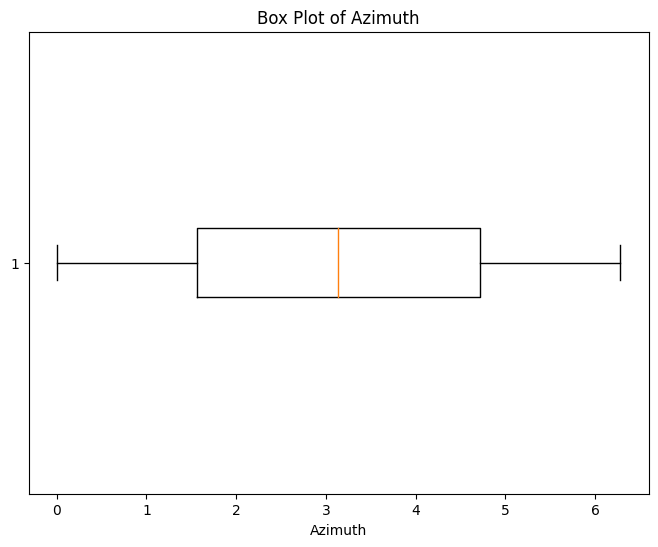

In [29]:
az = filtered_df.select("azimuth").toPandas()
plt.figure(figsize=(8, 6))
plt.boxplot(az["azimuth"], vert=False)
plt.xlabel('Azimuth')
plt.title('Box Plot of Azimuth')
plt.show()

24/05/09 15:13:56 WARN TaskSetManager: Stage 302 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.


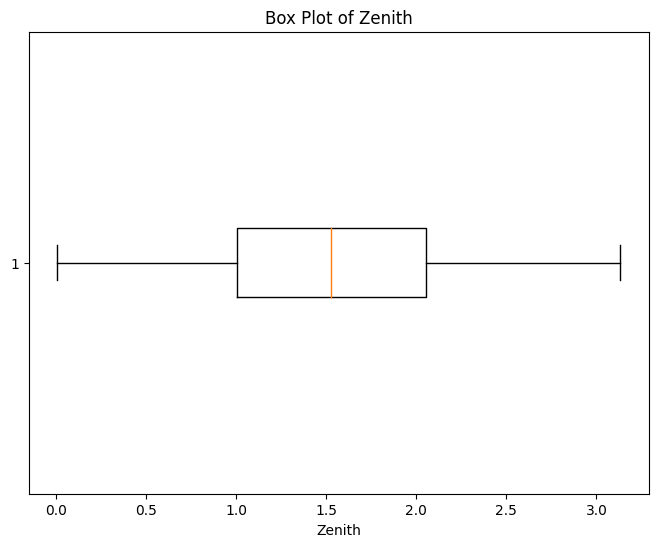

In [30]:
zen = filtered_df.select("zenith").toPandas()
plt.figure(figsize=(8, 6))
plt.boxplot(zen["zenith"], vert=False)
plt.xlabel('Zenith')
plt.title('Box Plot of Zenith')
plt.show()

Interactive plots of sensor distribution in the Icecube Observatory.

In [31]:
pd_sensor = sen.toPandas()
fig = px.scatter_3d(pd_sensor, x='x', y='y', z='z', color='z', opacity=0.5)
fig.show()

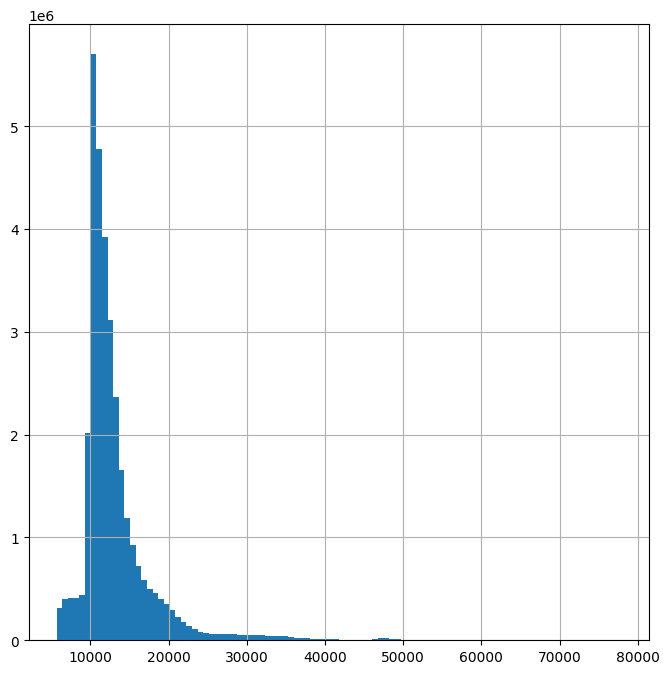

In [32]:
b1_df_pd = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_1.parquet')
b1_df_pd['time'].hist(bins=100, figsize=(8, 8))
plt.show()

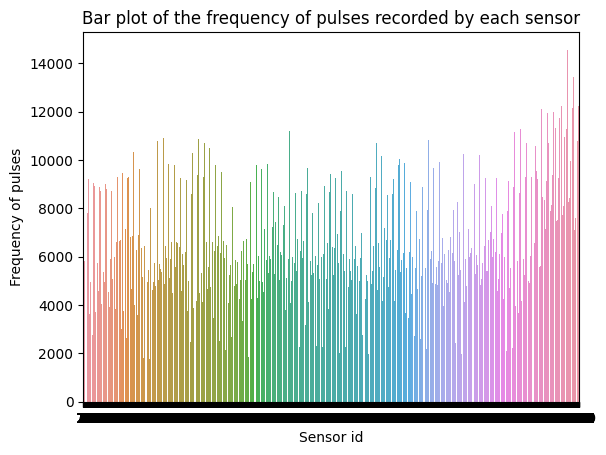

In [33]:
sensor_counts = b1_df_pd['sensor_id'].value_counts()

sns.barplot(x=sensor_counts.index, y=sensor_counts.values)
plt.xlabel('Sensor id')
plt.ylabel('Frequency of pulses')
plt.title('Bar plot of the frequency of pulses recorded by each sensor')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version

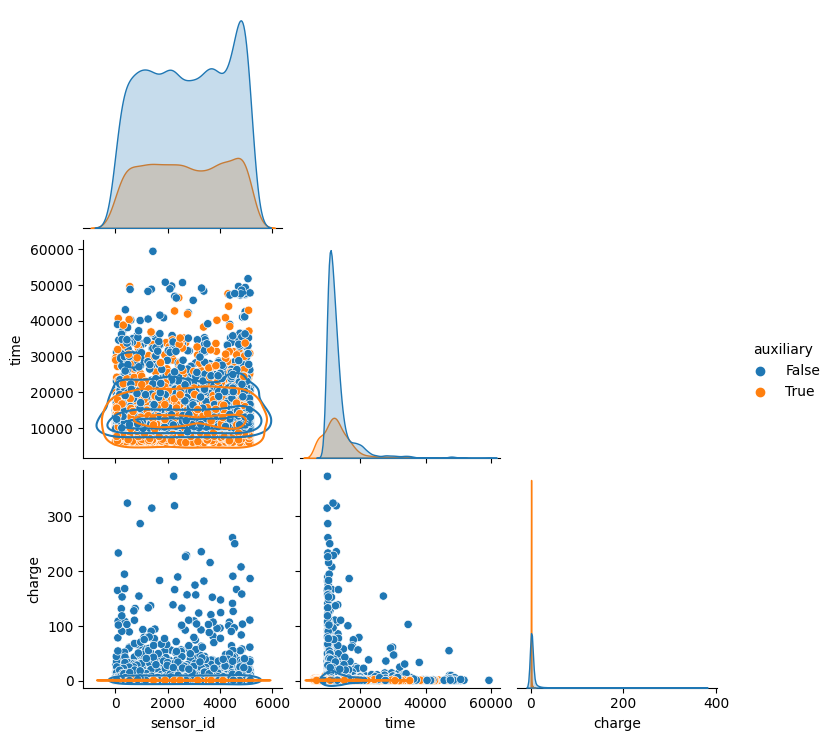

In [34]:
batch_1_sample = b1_df_pd.sample(10**4)
g = sns.pairplot(batch_1_sample, hue='auxiliary', diag_kind="kde", corner=True)
g.map_lower(sns.kdeplot, levels=4)
plt.show()

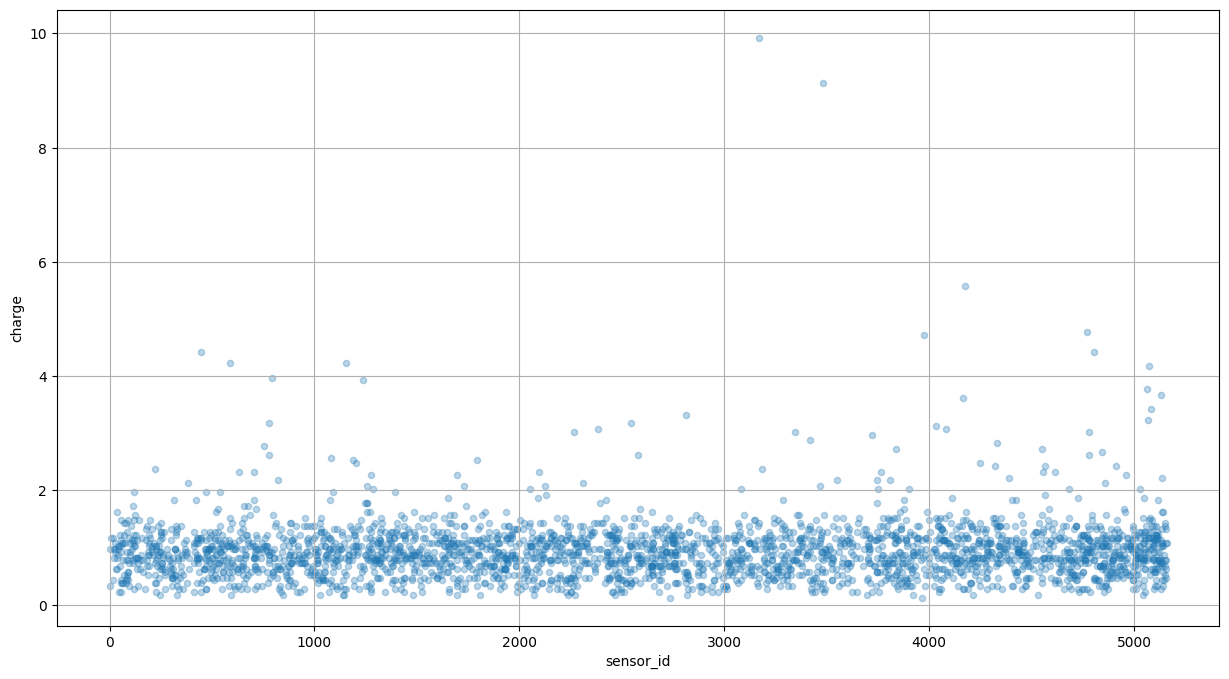

In [35]:
batch_1_sample.loc[batch_1_sample['auxiliary'] == True].plot(x='sensor_id', y='charge', kind='scatter', grid=True, figsize=(15,8), alpha=0.3)
plt.show()

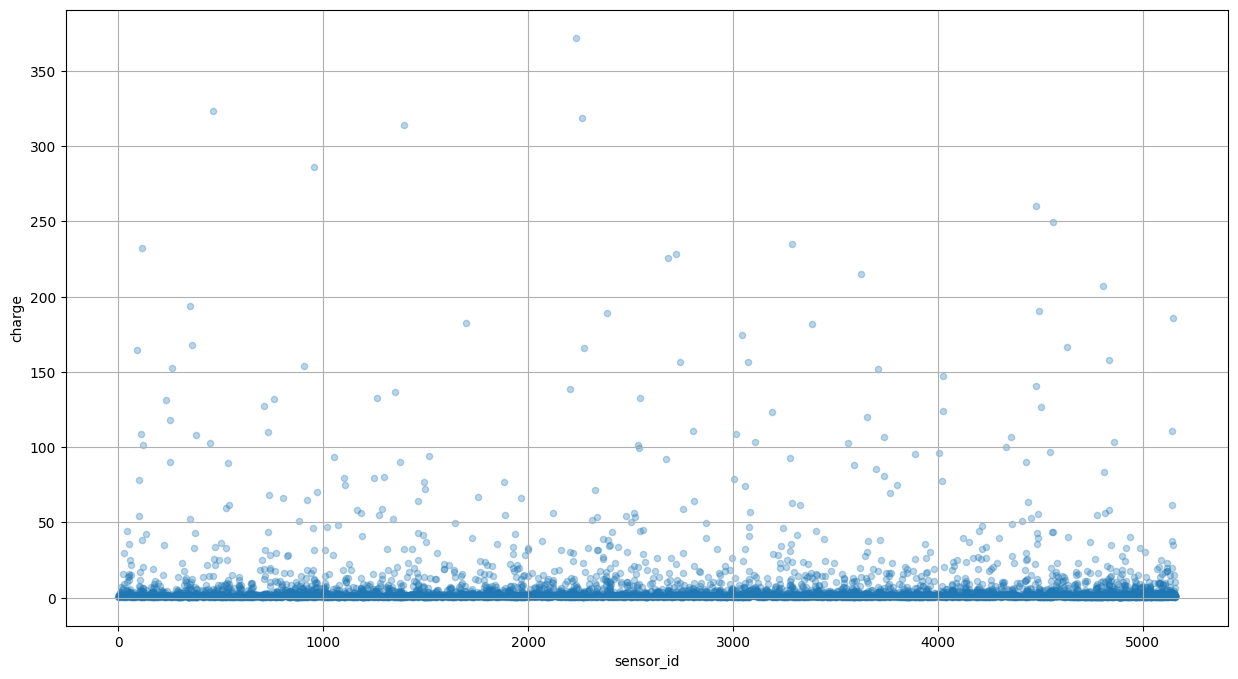

In [36]:
batch_1_sample.loc[batch_1_sample['auxiliary'] == False].plot(x='sensor_id', y='charge', kind='scatter', grid=True, figsize=(15,8), alpha=0.3)
plt.show()

In [37]:
#sensor = pd.read_csv('/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')
#df = pd.read_csv("/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv")
train_meta = pq.ParquetFile('/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet')
it = train_meta.iter_batches()
train_meta = next(it).to_pandas()

def get_batch(batchfile):
    batch1 = pq.ParquetFile(batchfile)
    it = batch1.iter_batches()
    batch1 = next(it).to_pandas()
    return(batch1)

path_batch = '/kaggle/input/icecube-neutrinos-in-deep-ice/train/'
sensor_info = [get_batch(path_batch+'batch_'+str(i+1)+'.parquet') for i in tqdm(range(len(os.listdir(path_batch))))]

aux_true = []
for s in tqdm(sensor_info):
    aux_true.append(pd.DataFrame(s[s.auxiliary==True][['sensor_id','auxiliary']].value_counts()).sort_index())

100%|██████████| 660/660 [00:05<00:00, 119.48it/s]


In [38]:
aux_true = pd.concat(aux_true).reset_index().drop('auxiliary',axis=1)
aux_true_result = aux_true.groupby('sensor_id').sum()
aux_true_result.columns = ['Num_Aux_True']

Text(0.5, 1.0, 'Distribution of cumulative Auxiliary number per sensors')

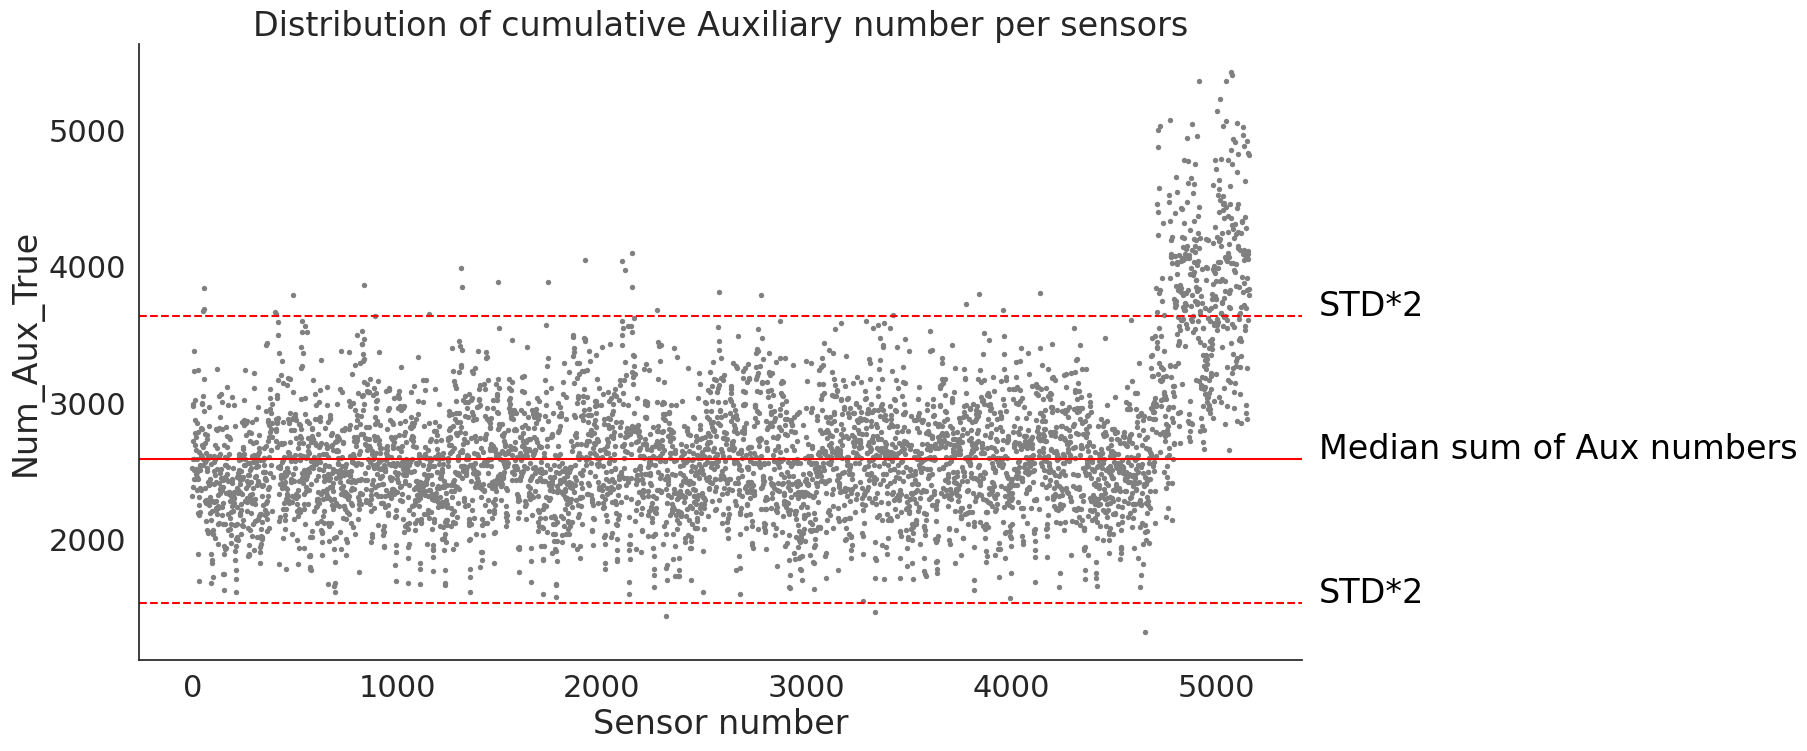

In [39]:
std_t2_p = aux_true_result.Num_Aux_True.median() + 2*aux_true_result.Num_Aux_True.std()
std_t2_m = aux_true_result.Num_Aux_True.median() - 2*aux_true_result.Num_Aux_True.std()


sns.set(font_scale = 2,style = 'white')
plt.figure(figsize = (15,8))
sns.scatterplot(data = aux_true_result,x = aux_true_result.index.tolist(),y = 'Num_Aux_True',linewidth =0,s = 15,color = 'grey')
plt.axhline(aux_true_result.Num_Aux_True.median(),color = 'red')
plt.axhline(std_t2_p,color = 'red',linestyle='--')
plt.axhline(std_t2_m,color = 'red',linestyle='--')

plt.text(5500,aux_true_result.Num_Aux_True.median(),'Median sum of Aux numbers',color = 'black')
plt.text(5500,std_t2_p,'STD*2',color = 'black')
plt.text(5500,std_t2_m,'STD*2',color = 'black')

sns.despine()
plt.xlabel('Sensor number')
plt.title('Distribution of cumulative Auxiliary number per sensors')

In [40]:
sensor = pd.read_csv('/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')
sensor_under_std2 = aux_true_result[aux_true_result.Num_Aux_True<std_t2_m].index.tolist()
sensor_over_std2 = aux_true_result[aux_true_result.Num_Aux_True>std_t2_p].index.tolist()
sensor['Outlier_sensors'] = 'Normal'
sensor.loc[sensor.sensor_id.isin(sensor_under_std2), 'Outlier_sensors'] = '< 2*STD'
sensor.loc[sensor.sensor_id.isin(sensor_over_std2), 'Outlier_sensors'] = '> 2*STD'

In [41]:
fig = px.scatter_3d(sensor, x='x', y='y', z='z', color='Outlier_sensors', size='sensor_id',
                   title="IceCube Observatory : Visualization of irregular sensors")

fig.show()

# PART 4. Vector Databases and Data Querying:

## 4A: Extract Azimuth / Zenith Values and Normalize them:

In [42]:
meta_data = filtered_df.toPandas()
azimuth = meta_data['azimuth'].values.astype(np.float32)
zenith = meta_data['zenith'].values.astype(np.float32)

print(azimuth)
print(zenith)

24/05/09 15:46:23 WARN TaskSetManager: Stage 304 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 15:46:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:46:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:46:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:46:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:46:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:46:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:46:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/09 15:46:56 WARN RowBasedKeyValu

[0.6537188  0.01137151 0.3672298  ... 0.88470936 0.656511   5.5009046 ]
[0.93911725 1.2953707  2.667595   ... 1.9056692  1.8063172  2.5032098 ]


In [43]:
azimuth_norm = np.cos(azimuth) * np.sin(zenith)
zenith_norm = np.sin(azimuth) * np.sin(zenith)

print(azimuth_norm)
print(zenith_norm)

[0.6406485  0.9622473  0.42601356 ... 0.598324   0.7702583  0.42267472]
[ 0.4907938   0.01094268  0.16387874 ...  0.73075175  0.5935067
 -0.4200476 ]


## 4B: Create and Index Directional data:

In [44]:
# Stack azimuth and zenith data into a single array
directional_data = np.column_stack((azimuth_norm, zenith_norm))
print(directional_data)

[[ 0.6406485   0.4907938 ]
 [ 0.9622473   0.01094268]
 [ 0.42601356  0.16387874]
 ...
 [ 0.598324    0.73075175]
 [ 0.7702583   0.5935067 ]
 [ 0.42267472 -0.4200476 ]]


In [45]:
index = faiss.IndexFlatL2(2)  # L2 distance for 2D data
index.add(directional_data)

## 4C: Take Test Input for Queries:

In [46]:
# az = float(input('Enter Test Azimuth:'))
# zen = float(input('Enter Test Zenith:'))
# query_direction = np.array([az, zen])
query_direction = np.array([0.5, 0.5])
query_direction = query_direction.reshape(1, -1).astype(np.float32)

## 4D: Query 1 - Nearest Neightbours:

In [47]:
k = 5  # Number of nearest neighbors to retrieve
distances, indices = index.search(query_direction, k)

print("Indices:", indices)
print("Distances:", distances)
meta_data.iloc[indices[0]]

Indices: [[ 20100  45378  56724 199771 183619]]
Distances: [[3.0684637e-06 1.5687856e-05 4.2209118e-05 4.4339617e-05 5.2112868e-05]]


,event_id,batch_id,first_pulse_index,last_pulse_index,azimuth,zenith,n_pulses,n_unique_pulses,unique%,min_time,...,avg_time,min_charge,max_charge,avg_charge,false,true,dig%,x,y,z
20100,1324010,1,12931039,12931078,0.784207,0.787572,39,31,44.285714,5923,...,10396.625000,0.225,1.725,0.820000,15,25,37.500000,0.501682,0.500488,0.705568
45378,3015674,1,29959236,29959324,0.782781,0.790359,88,62,41.333333,6082,...,11304.617978,0.125,5.375,1.059831,32,57,35.955056,0.503788,0.501158,0.703590
56724,503647,1,4817731,4817789,0.778050,2.350690,58,47,44.761905,5908,...,11061.966102,0.225,1.625,0.789407,19,40,32.203390,0.506425,0.499037,-0.703204
199771,3251853,1,32507120,32507158,0.794238,0.788610,38,34,47.222222,6411,...,11148.666667,0.275,1.925,0.921154,8,31,20.512821,0.497150,0.506018,0.704832
183619,2238013,1,22062271,22062316,0.779061,2.348178,45,39,46.428571,5913,...,10692.391304,0.325,2.375,0.959783,9,37,19.565217,0.507176,0.500788,-0.701416


## 4E: Query 2 - Range Search:

In [48]:
radius = 0.1 
distances_indices = index.range_search(query_direction, radius)
distances_range = distances_indices[0]
indices_range = distances_indices[1]

print("Indices:", indices_range)
print("Distances:", distances_range)
meta_data.iloc[indices_range]

Indices: [0.01986675 0.04907027 0.03935234 ... 0.09124903 0.06291398 0.08178306]
Distances: [    0 18121]


,event_id,batch_id,first_pulse_index,last_pulse_index,azimuth,zenith,n_pulses,n_unique_pulses,unique%,min_time,...,avg_time,min_charge,max_charge,avg_charge,false,true,dig%,x,y,z
0,72,1,290,351,0.653719,0.939117,61,48,44.036697,6083,...,11433.064516,0.125,1.675,0.899194,20,42,32.258065,0.640648,0.490794,0.590501
0,72,1,290,351,0.653719,0.939117,61,48,44.036697,6083,...,11433.064516,0.125,1.675,0.899194,20,42,32.258065,0.640648,0.490794,0.590501
0,72,1,290,351,0.653719,0.939117,61,48,44.036697,6083,...,11433.064516,0.125,1.675,0.899194,20,42,32.258065,0.640648,0.490794,0.590501
0,72,1,290,351,0.653719,0.939117,61,48,44.036697,6083,...,11433.064516,0.125,1.675,0.899194,20,42,32.258065,0.640648,0.490794,0.590501
0,72,1,290,351,0.653719,0.939117,61,48,44.036697,6083,...,11433.064516,0.125,1.675,0.899194,20,42,32.258065,0.640648,0.490794,0.590501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,72,1,290,351,0.653719,0.939117,61,48,44.036697,6083,...,11433.064516,0.125,1.675,0.899194,20,42,32.258065,0.640648,0.490794,0.590501
0,72,1,290,351,0.653719,0.939117,61,48,44.036697,6083,...,11433.064516,0.125,1.675,0.899194,20,42,32.258065,0.640648,0.490794,0.590501
0,72,1,290,351,0.653719,0.939117,61,48,44.036697,6083,...,11433.064516,0.125,1.675,0.899194,20,42,32.258065,0.640648,0.490794,0.590501
0,72,1,290,351,0.653719,0.939117,61,48,44.036697,6083,...,11433.064516,0.125,1.675,0.899194,20,42,32.258065,0.640648,0.490794,0.590501


## 4F: Query 3 - Approximate Nearest Neighbours:

In [49]:
# Build an index for approximate nearest neighbor search
quantizer = faiss.IndexFlatL2(2)
index_ann = faiss.IndexIVFFlat(quantizer, 2, 100)
index_ann.train(directional_data)
index_ann.add(directional_data)

distances_ann, indices_ann = index_ann.search(query_direction, k)
print("Approximate Nearest Neighbor Search Results:")
print("Indices:", indices_ann)
print("Distances:", distances_ann)
meta_data.iloc[indices_ann[0]]

Approximate Nearest Neighbor Search Results:
Indices: [[ 20100  45378  56724 199771 183619]]
Distances: [[3.0684637e-06 1.5687856e-05 4.2209118e-05 4.4339617e-05 5.2112868e-05]]


,event_id,batch_id,first_pulse_index,last_pulse_index,azimuth,zenith,n_pulses,n_unique_pulses,unique%,min_time,...,avg_time,min_charge,max_charge,avg_charge,false,true,dig%,x,y,z
20100,1324010,1,12931039,12931078,0.784207,0.787572,39,31,44.285714,5923,...,10396.625000,0.225,1.725,0.820000,15,25,37.500000,0.501682,0.500488,0.705568
45378,3015674,1,29959236,29959324,0.782781,0.790359,88,62,41.333333,6082,...,11304.617978,0.125,5.375,1.059831,32,57,35.955056,0.503788,0.501158,0.703590
56724,503647,1,4817731,4817789,0.778050,2.350690,58,47,44.761905,5908,...,11061.966102,0.225,1.625,0.789407,19,40,32.203390,0.506425,0.499037,-0.703204
199771,3251853,1,32507120,32507158,0.794238,0.788610,38,34,47.222222,6411,...,11148.666667,0.275,1.925,0.921154,8,31,20.512821,0.497150,0.506018,0.704832
183619,2238013,1,22062271,22062316,0.779061,2.348178,45,39,46.428571,5913,...,10692.391304,0.325,2.375,0.959783,9,37,19.565217,0.507176,0.500788,-0.701416


## 4G: Query 4 - Cosine Similarity Search:

In [50]:
# Build an index for cosine similarity search
index_cosine = faiss.IndexFlatIP(2)  # Index for inner product (cosine similarity)
index_cosine.add(directional_data)

distances_cosine, indices_cosine = index_cosine.search(query_direction, k)
print("Cosine Similarity Search Results:")
print("Indices:", indices_cosine)
print("Distances:", distances_cosine)
meta_data.iloc[indices_cosine[0]]

Cosine Similarity Search Results:
Indices: [[104488  65135  49576  72536  28958]]
Distances: [[0.70710063 0.7070899  0.70707947 0.7070583  0.7070472 ]]


,event_id,batch_id,first_pulse_index,last_pulse_index,azimuth,zenith,n_pulses,n_unique_pulses,unique%,min_time,...,avg_time,min_charge,max_charge,avg_charge,false,true,dig%,x,y,z
104488,402657,1,3806960,3807065,0.781563,1.572446,105,77,42.307692,5887,...,11557.698113,0.225,2.625,0.897170,40,66,37.735849,0.709813,0.704389,-0.001649
65135,1062910,1,10150795,10150860,0.779759,1.566810,65,42,39.252336,6092,...,10994.075758,0.125,1.975,0.899242,29,37,43.939394,0.711078,0.703102,0.003987
49576,31174,1,291354,291421,0.787329,1.579371,67,47,41.228070,5916,...,10923.426471,0.175,2.975,0.931618,27,41,39.705882,0.705714,0.708445,-0.008575
72536,1553794,1,15103873,15103935,0.773732,1.569866,62,47,43.119266,5878,...,11374.460317,0.225,3.375,0.986905,24,39,38.095238,0.715308,0.698809,0.000930
28958,1923577,1,18905843,18905883,0.785704,1.583769,40,37,48.051948,5974,...,10719.317073,0.225,3.125,0.973780,7,34,17.073171,0.706831,0.707264,-0.012973


## 4H: Query 5 - Batch Search:

In [51]:
# Example batch of query directions
batch_query_directions = np.array([[0.5, 0.5], [0.2, 0.8], [0.7, 0.3]])
batch_query_directions = batch_query_directions.astype(np.float32)

distances_batch, indices_batch = index.search(batch_query_directions, k)
print("Indices:", indices_batch)
print("Distances:", distances_batch)
meta_data.iloc[indices_batch[0]]

Indices: [[ 20100  45378  56724 199771 183619]
 [163948 124344   6180  14868  32375]
 [151524 164168  61988 126696   2930]]
Distances: [[3.06846368e-06 1.56878559e-05 4.22091180e-05 4.43396166e-05
  5.21128677e-05]
 [4.17866113e-06 5.83202564e-06 6.08112623e-06 1.15017565e-05
  2.97158185e-05]
 [7.03142086e-06 9.47811168e-06 1.05848030e-05 1.17867230e-05
  3.13239216e-05]]


,event_id,batch_id,first_pulse_index,last_pulse_index,azimuth,zenith,n_pulses,n_unique_pulses,unique%,min_time,...,avg_time,min_charge,max_charge,avg_charge,false,true,dig%,x,y,z
20100,1324010,1,12931039,12931078,0.784207,0.787572,39,31,44.285714,5923,...,10396.625000,0.225,1.725,0.820000,15,25,37.500000,0.501682,0.500488,0.705568
45378,3015674,1,29959236,29959324,0.782781,0.790359,88,62,41.333333,6082,...,11304.617978,0.125,5.375,1.059831,32,57,35.955056,0.503788,0.501158,0.703590
56724,503647,1,4817731,4817789,0.778050,2.350690,58,47,44.761905,5908,...,11061.966102,0.225,1.625,0.789407,19,40,32.203390,0.506425,0.499037,-0.703204
199771,3251853,1,32507120,32507158,0.794238,0.788610,38,34,47.222222,6411,...,11148.666667,0.275,1.925,0.921154,8,31,20.512821,0.497150,0.506018,0.704832
183619,2238013,1,22062271,22062316,0.779061,2.348178,45,39,46.428571,5913,...,10692.391304,0.325,2.375,0.959783,9,37,19.565217,0.507176,0.500788,-0.701416


# PART 5. Simulation of Spark Streaming:

In [62]:
e_counts = b1_df_spark.groupBy("sensor_id").count()
e_counts.show()

+---------+-----+
|sensor_id|count|
+---------+-----+
|     3918| 5364|
|     2142| 5906|
|     1829| 4973|
|     2866| 8460|
|      471|10618|
|      148| 5812|
|     2659| 6677|
|     5156|13280|
|     4900|11819|
|      463| 7413|
|     2122| 6357|
|     3175| 8771|
|     1580| 6395|
|     3749| 5796|
|     4935| 7306|
|     1342| 6776|
|      496| 5351|
|      833| 8036|
|     1238| 4125|
|     1088| 3793|
+---------+-----+
only showing top 20 rows



In [63]:
temp_directory = '/kaggle/working/temp/'
stream_directory = '/kaggle/working/streaming_source/'

if os.path.exists(temp_directory):
    shutil.rmtree(temp_directory)

if os.path.exists(stream_directory):
    shutil.rmtree(stream_directory)

os.makedirs(temp_directory, exist_ok=True)
os.makedirs(stream_directory, exist_ok=True)

In [64]:
number_of_chunks = 50
b1_df_spark.repartition(number_of_chunks).write.parquet(temp_directory, mode='overwrite')

In [65]:
chunk_files = [os.path.join(temp_directory, name) for name in os.listdir(temp_directory)]
chunk_files

['/kaggle/working/temp/part-00003-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet',
 '/kaggle/working/temp/_SUCCESS',
 '/kaggle/working/temp/.part-00015-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc',
 '/kaggle/working/temp/.part-00037-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc',
 '/kaggle/working/temp/.part-00021-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc',
 '/kaggle/working/temp/part-00004-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet',
 '/kaggle/working/temp/part-00010-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet',
 '/kaggle/working/temp/.part-00007-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc',
 '/kaggle/working/temp/.part-00012-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc',
 '/kaggle/working/temp/part-00009-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet',
 '/kaggle/working/temp/.part-00022-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc',
 '/kag

In [66]:
schema = b1_df_spark.schema

streaming_df = spark.readStream.schema(schema).parquet(stream_directory)

# chosen computation
event_counts = streaming_df.groupBy("sensor_id").count()

query = event_counts.writeStream \
    .outputMode("complete") \
    .format("console") \
    .trigger(processingTime='3 seconds') \
    .start()

try:
    for file_path in chunk_files:
        # Move chunk to the streaming directory
        dest_path = os.path.join(stream_directory, os.path.basename(file_path))
        shutil.move(file_path, dest_path)
        print(f"Moved '{file_path}'")
        time.sleep(1) 
    query.awaitTermination()
except KeyboardInterrupt:
    print("Streaming stopped.")

query.stop()

24/05/09 15:59:49 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-0fd8232c-e2c5-4545-80a1-f436cf122a26. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/05/09 15:59:49 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


Moved '/kaggle/working/temp/part-00003-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/_SUCCESS'


Moved '/kaggle/working/temp/.part-00015-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/.part-00037-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/.part-00021-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


-------------------------------------------
Batch: 0
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122|  115|
|     1580|  132|
|      496|  122|
|     4935|  154|
|     2366|  117|
|      471|  214|
|     5156|  250|
|     4101|  108|
|     1959|  118|
|     2866|  180|
|     1645|  103|
|     1238|   75|
|     1088|   83|
|      833|  167|
|     4818|  142|
|     1591|   73|
|      148|  130|
|     3794|  131|
|     1342|  130|
|     4900|  237|
+---------+-----+
only showing top 20 rows

Moved '/kaggle/working/temp/part-00004-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


24/05/09 15:59:54 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 5097 milliseconds


Moved '/kaggle/working/temp/part-00010-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00007-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/.part-00012-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00009-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'
-------------------------------------------
Batch: 1
-------------------------------------------


+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 6089|
|     1580| 6170|
|     2366| 5772|
|      471|10226|
|     4101| 5488|
|     1959| 5296|
|     1645| 4604|
|     1088| 3661|
|      833| 7706|
|     3794| 6647|
|     4900|11401|
|     3997| 2339|
|     3175| 8454|
|     1829| 4775|
|      463| 7096|
|     3918| 5122|
|      496| 5160|
|     4935| 7023|
|     5156|12724|
|     2866| 8112|
+---------+-----+
only showing top 20 rows



24/05/09 15:59:59 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 8092 milliseconds


Moved '/kaggle/working/temp/.part-00022-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/._SUCCESS.crc'


Moved '/kaggle/working/temp/.part-00008-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/.part-00034-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


-------------------------------------------
Batch: 1
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 6089|
|     1580| 6170|
|     2366| 5772|
|      471|10226|
|     4101| 5488|
|     1959| 5296|
|     1645| 4604|
|     1088| 3661|
|      833| 7706|
|     3794| 6647|
|     4900|11401|
|     3997| 2339|
|     3175| 8454|
|     1829| 4775|
|      463| 7096|
|     3918| 5122|
|      496| 5160|
|     4935| 7023|
|     5156|12724|
|     2866| 8112|
+---------+-----+
only showing top 20 rows



24/05/09 16:00:03 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 12348 milliseconds


Moved '/kaggle/working/temp/part-00027-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/part-00018-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00004-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00030-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


-------------------------------------------
Batch: 1
-------------------------------------------
Moved '/kaggle/working/temp/part-00024-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122|  248|
|     1580|  250|
|     2366|  247|
|      471|  442|
|     4101|  209|
|     1959|  234|
|     1645|  196|
|     1088|  164|
|      833|  326|
|     3794|  257|
|     4900|  501|
|     3997|   96|
|     3175|  335|
|      463|  290|
|     1829|  201|
|     3918|  212|
|      496|  222|
|     4935|  304|
|     5156|  513|
|     2866|  341|
+---------+-----+
only showing top 20 rows



24/05/09 16:00:07 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 13040 milliseconds


Moved '/kaggle/working/temp/.part-00006-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00012-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00031-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00019-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'
-------------------------------------------
Batch: 2
-------------------------------------------


+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 6484|
|     1580| 6555|
|     2366| 6157|
|      471|10846|
|     4101| 5816|
|     1959| 5649|
|     1645| 4898|
|     1088| 3884|
|      833| 8158|
|     3794| 7053|
|     4900|12149|
|     3997| 2484|
|     3175| 8975|
|     1829| 5071|
|      463| 7518|
|     3918| 5436|
|      496| 5473|
|     4935| 7483|
|     5156|13531|
|     2866| 8624|
+---------+-----+
only showing top 20 rows



24/05/09 16:00:12 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 12940 milliseconds


Moved '/kaggle/working/temp/part-00026-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00024-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00046-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/part-00049-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


24/05/09 16:00:16 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 12796 milliseconds


-------------------------------------------
Batch: 2
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 6484|
|     1580| 6555|
|     2366| 6157|
|      471|10846|
|     4101| 5816|
|     1959| 5649|
|     1645| 4898|
|     1088| 3884|
|      833| 8158|
|     3794| 7053|
|     4900|12149|
|     3997| 2484|
|     3175| 8975|
|     1829| 5071|
|      463| 7518|
|     3918| 5436|
|      496| 5473|
|     4935| 7483|
|     5156|13531|
|     2866| 8624|
+---------+-----+
only showing top 20 rows

Moved '/kaggle/working/temp/.part-00042-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00043-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00019-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00037-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


-------------------------------------------
Batch: 2
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 1053|
|     1580|  998|
|     2366|  982|
|      471| 1749|
|     4101|  873|
|     1959|  905|
|     1645|  780|
|     1088|  606|
|      833| 1276|
|     3794| 1119|
|     4900| 1892|
|     3997|  372|
|     3175| 1418|
|      463| 1169|
|     1829|  801|
|     3918|  841|
|      496|  875|
|     4935| 1199|
|     5156| 2077|
|     2866| 1378|
+---------+-----+
only showing top 20 rows

Moved '/kaggle/working/temp/part-00002-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


24/05/09 16:00:20 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 12885 milliseconds


Moved '/kaggle/working/temp/.part-00028-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/.part-00045-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00013-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/part-00047-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'
-------------------------------------------
Batch: 3
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 7276|
|     1580| 7271|
|     2366| 6872|
|      471|12167|
|     4101| 6489|
|     1959| 6333|
|     1645| 5457|
|     1088| 4345|
|      833| 9149|
|     3794| 7913|
|     4900|13539|
|     3997| 2752|
|     3175|10039|
|     1829| 5683|
|      463| 8420|
|     3918| 6107|
|      496| 6138|
|     4935| 8343|
|     5156|15081|
|     2866| 9641|
+---------+-----+
only showing top 20 rows



24/05/09 16:00:25 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 13027 milliseconds


Moved '/kaggle/working/temp/.part-00048-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/.part-00046-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00020-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00032-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/.part-00033-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'
-------------------------------------------
Batch: 3
-------------------------------------------


+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 7636|
|     1580| 7607|
|     2366| 7224|
|      471|12789|
|     4101| 6832|
|     1959| 6648|
|     1645| 5740|
|     1088| 4563|
|      833| 9650|
|     3794| 8387|
|     4900|14225|
|     3997| 2909|
|     3175|10523|
|     1829| 5993|
|      463| 8904|
|     3918| 6432|
|      496| 6429|
|     4935| 8795|
|     5156|15883|
|     2866|10177|
+---------+-----+
only showing top 20 rows



24/05/09 16:00:30 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 13884 milliseconds


Moved '/kaggle/working/temp/part-00033-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00043-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/.part-00044-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/.part-00016-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


-------------------------------------------
Batch: 3
-------------------------------------------


+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 1898|
|     1580| 1813|
|     2366| 1797|
|      471| 3206|
|     4101| 1673|
|     1959| 1698|
|     1645| 1437|
|     1088| 1128|
|      833| 2426|
|     3794| 2155|
|     4900| 3561|
|     3997|  712|
|     3175| 2602|
|      463| 2278|
|     1829| 1529|
|     3918| 1648|
|      496| 1603|
|     4935| 2232|
|     5156| 3950|
|     2866| 2544|
+---------+-----+
only showing top 20 rows

Moved '/kaggle/working/temp/.part-00047-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


24/05/09 16:00:34 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 14082 milliseconds


Moved '/kaggle/working/temp/part-00045-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00026-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00032-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/part-00044-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'
-------------------------------------------
Batch: 4
-------------------------------------------


+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 8255|
|     1580| 8256|
|     2366| 7818|
|      471|13903|
|     4101| 7413|
|     1959| 7182|
|     1645| 6217|
|     1088| 4926|
|      833|10452|
|     3794| 9065|
|     4900|15439|
|     3997| 3150|
|     3175|11423|
|     1829| 6472|
|      463| 9644|
|     3918| 6961|
|      496| 6951|
|     4935| 9506|
|     5156|17241|
|     2866|10966|
+---------+-----+
only showing top 20 rows



24/05/09 16:00:39 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 13971 milliseconds


Moved '/kaggle/working/temp/.part-00038-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/.part-00035-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00028-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00039-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


-------------------------------------------
Batch: 4
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 8375|
|     1580| 8349|
|     2366| 7949|
|      471|14107|
|     4101| 7526|
|     1959| 7294|
|     1645| 6316|
|     1088| 5008|
|      833|10598|
|     3794| 9188|
|     4900|15667|
|     3997| 3198|
|     3175|11595|
|     1829| 6552|
|      463| 9792|
|     3918| 7065|
|      496| 7083|
|     4935| 9640|
|     5156|17518|
|     2866|11145|
+---------+-----+
only showing top 20 rows



24/05/09 16:00:43 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 13253 milliseconds


Moved '/kaggle/working/temp/part-00048-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00009-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00014-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/part-00042-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


-------------------------------------------
Batch: 4
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 2523|
|     1580| 2467|
|     2366| 2395|
|      471| 4291|
|     4101| 2282|
|     1959| 2227|
|     1645| 1897|
|     1088| 1499|
|      833| 3233|
|     3794| 2817|
|     4900| 4754|
|     3997|  964|
|     3175| 3477|
|      463| 2990|
|     1829| 1968|
|     3918| 2165|
|      496| 2153|
|     4935| 2898|
|     5156| 5303|
|     2866| 3380|
+---------+-----+
only showing top 20 rows

Moved '/kaggle/working/temp/part-00008-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


24/05/09 16:00:47 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 13013 milliseconds


Moved '/kaggle/working/temp/.part-00023-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00029-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/part-00000-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


-------------------------------------------
Batch: 5
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 8879|
|     1580| 8905|
|     2366| 8415|
|      471|14937|
|     4101| 8013|
|     1959| 7739|
|     1645| 6697|
|     1088| 5297|
|      833|11252|
|     3794| 9756|
|     4900|16636|
|     3997| 3415|
|     3175|12264|
|     1829| 6918|
|      463|10385|
|     3918| 7478|
|      496| 7495|
|     4935|10191|
|     5156|18572|
|     2866|11810|
+---------+-----+
only showing top 20 rows

Moved '/kaggle/working/temp/part-00006-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


24/05/09 16:00:51 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 12684 milliseconds


Moved '/kaggle/working/temp/part-00041-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/part-00016-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00011-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00022-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


-------------------------------------------
Batch: 5
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 9004|
|     1580| 9028|
|     2366| 8543|
|      471|15153|
|     4101| 8133|
|     1959| 7851|
|     1645| 6791|
|     1088| 5363|
|      833|11411|
|     3794| 9905|
|     4900|16862|
|     3997| 3464|
|     3175|12441|
|     1829| 7019|
|      463|10525|
|     3918| 7609|
|      496| 7601|
|     4935|10352|
|     5156|18848|
|     2866|11956|
+---------+-----+
only showing top 20 rows



24/05/09 16:00:56 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 13141 milliseconds


Moved '/kaggle/working/temp/.part-00041-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/.part-00013-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00038-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00025-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


-------------------------------------------
Batch: 5
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 3541|
|     1580| 3528|
|     2366| 3348|
|      471| 5989|
|     4101| 3207|
|     1959| 3122|
|     1645| 2660|
|     1088| 2077|
|      833| 4490|
|     3794| 3963|
|     4900| 6606|
|     3997| 1356|
|     3175| 4877|
|      463| 4221|
|     1829| 2756|
|     3918| 3036|
|      496| 2999|
|     4935| 4054|
|     5156| 7486|
|     2866| 4705|
+---------+-----+
only showing top 20 rows

Moved '/kaggle/working/temp/part-00001-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


24/05/09 16:01:00 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 13074 milliseconds


Moved '/kaggle/working/temp/.part-00005-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/.part-00020-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00025-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00036-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'
-------------------------------------------
Batch: 6
-------------------------------------------


+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 9912|
|     1580| 9959|
|     2366| 9341|
|      471|16657|
|     4101| 8943|
|     1959| 8638|
|     1645| 7442|
|     1088| 5879|
|      833|12541|
|     3794|10929|
|     4900|18491|
|     3997| 3792|
|     3175|13703|
|     1829| 7737|
|      463|11577|
|     3918| 8356|
|      496| 8376|
|     4935|11371|
|     5156|20707|
|     2866|13146|
+---------+-----+
only showing top 20 rows



24/05/09 16:01:05 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 13400 milliseconds


Moved '/kaggle/working/temp/.part-00010-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00007-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00014-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/.part-00029-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


-------------------------------------------
Batch: 6
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122|10284|
|     1580|10348|
|     2366| 9716|
|      471|17287|
|     4101| 9293|
|     1959| 8978|
|     1645| 7732|
|     1088| 6084|
|      833|13020|
|     3794|11309|
|     4900|19178|
|     3997| 3949|
|     3175|14221|
|     1829| 8052|
|      463|12040|
|     3918| 8678|
|      496| 8712|
|     4935|11800|
|     5156|21517|
|     2866|13668|
+---------+-----+
only showing top 20 rows



24/05/09 16:01:09 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 13058 milliseconds


Moved '/kaggle/working/temp/part-00039-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/part-00015-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/part-00011-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00030-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


-------------------------------------------
Batch: 6
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 4571|
|     1580| 4565|
|     2366| 4315|
|      471| 7689|
|     4101| 4125|
|     1959| 4008|
|     1645| 3440|
|     1088| 2666|
|      833| 5813|
|     3794| 5075|
|     4900| 8480|
|     3997| 1772|
|     3175| 6314|
|      463| 5418|
|     1829| 3564|
|     3918| 3857|
|      496| 3896|
|     4935| 5256|
|     5156| 9576|
|     2866| 6067|
+---------+-----+
only showing top 20 rows



24/05/09 16:01:13 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 12730 milliseconds


Moved '/kaggle/working/temp/part-00034-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/part-00005-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00001-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/.part-00049-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


-------------------------------------------
Batch: 7
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122|10646|
|     1580|10740|
|     2366|10082|
|      471|17907|
|     4101| 9619|
|     1959| 9294|
|     1645| 8048|
|     1088| 6322|
|      833|13512|
|     3794|11732|
|     4900|19877|
|     3997| 4102|
|     3175|14778|
|     1829| 8345|
|      463|12478|
|     3918| 8983|
|      496| 9033|
|     4935|12266|
|     5156|22329|
|     2866|14170|
+---------+-----+
only showing top 20 rows

Moved '/kaggle/working/temp/part-00035-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


24/05/09 16:01:17 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 12648 milliseconds


Moved '/kaggle/working/temp/part-00040-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00018-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/.part-00000-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


-------------------------------------------
Batch: 7
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122|10776|
|     1580|10881|
|     2366|10209|
|      471|18149|
|     4101| 9726|
|     1959| 9405|
|     1645| 8139|
|     1088| 6395|
|      833|13682|
|     3794|11863|
|     4900|20148|
|     3997| 4153|
|     3175|14944|
|     1829| 8446|
|      463|12624|
|     3918| 9074|
|      496| 9159|
|     4935|12412|
|     5156|22599|
|     2866|14326|
+---------+-----+
only showing top 20 rows

Moved '/kaggle/working/temp/.part-00002-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


24/05/09 16:01:21 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 12296 milliseconds


Moved '/kaggle/working/temp/part-00031-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/part-00036-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/part-00017-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/.part-00040-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'
-------------------------------------------
Batch: 7
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 5184|
|     1580| 5205|
|     2366| 4911|
|      471| 8766|
|     4101| 4671|
|     1959| 4539|
|     1645| 3907|
|     1088| 3046|
|      833| 6642|
|     3794| 5751|
|     4900| 9682|
|     3997| 2021|
|     3175| 7171|
|      463| 6139|
|     1829| 4066|
|     3918| 4417|
|      496| 4419|
|     4935| 5986|
|     5156|10906|
|     2866| 6886|
+---------+-----+
only showing top 20 rows



24/05/09 16:01:25 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 12353 milliseconds


Moved '/kaggle/working/temp/.part-00003-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/.part-00017-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'


Moved '/kaggle/working/temp/part-00021-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


Moved '/kaggle/working/temp/part-00023-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet'


-------------------------------------------
Batch: 8
-------------------------------------------
Moved '/kaggle/working/temp/.part-00027-79a4ecad-56cd-4f18-84d8-aaf6c8d8e79c-c000.snappy.parquet.crc'
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122|11561|
|     1580|11655|
|     2366|10894|
|      471|19408|
|     4101|10401|
|     1959|10035|
|     1645| 8689|
|     1088| 6868|
|      833|14674|
|     3794|12650|
|     4900|21586|
|     3997| 4438|
|     3175|15992|
|     1829| 9055|
|      463|13497|
|     3918| 9760|
|      496| 9790|
|     4935|13289|
|     5156|24175|
|     2866|15326|
+---------+-----+
only showing top 20 rows



24/05/09 16:01:31 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 13425 milliseconds


-------------------------------------------
Batch: 8
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122|11691|
|     1580|11801|
|     2366|11023|
|      471|19609|
|     4101|10519|
|     1959|10144|
|     1645| 8792|
|     1088| 6950|
|      833|14813|
|     3794|12781|
|     4900|21793|
|     3997| 4504|
|     3175|16165|
|     1829| 9142|
|      463|13619|
|     3918| 9866|
|      496| 9883|
|     4935|13424|
|     5156|24430|
|     2866|15501|
+---------+-----+
only showing top 20 rows



24/05/09 16:01:36 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 14884 milliseconds


-------------------------------------------
Batch: 8
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 6090|
|     1580| 6148|
|     2366| 5748|
|      471|10238|
|     4101| 5497|
|     1959| 5286|
|     1645| 4584|
|     1088| 3629|
|      833| 7737|
|     3794| 6677|
|     4900|11361|
|     3997| 2345|
|     3175| 8421|
|      463| 7130|
|     1829| 4764|
|     3918| 5176|
|      496| 5146|
|     4935| 6986|
|     5156|12743|
|     2866| 8098|
+---------+-----+
only showing top 20 rows



24/05/09 16:01:41 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 15426 milliseconds


-------------------------------------------
Batch: 9
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122|12331|
|     1580|12433|
|     2366|11666|
|      471|20630|
|     4101|11106|
|     1959|10672|
|     1645| 9266|
|     1088| 7371|
|      833|15575|
|     3794|13462|
|     4900|22983|
|     3997| 4717|
|     3175|17049|
|     1829| 9647|
|      463|14350|
|     3918|10375|
|      496|10389|
|     4935|14175|
|     5156|25754|
|     2866|16392|
+---------+-----+
only showing top 20 rows



24/05/09 16:01:46 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 15013 milliseconds


-------------------------------------------
Batch: 9
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122|12331|
|     1580|12433|
|     2366|11666|
|      471|20630|
|     4101|11106|
|     1959|10672|
|     1645| 9266|
|     1088| 7371|
|      833|15575|
|     3794|13462|
|     4900|22983|
|     3997| 4717|
|     3175|17049|
|     1829| 9647|
|      463|14350|
|     3918|10375|
|      496|10389|
|     4935|14175|
|     5156|25754|
|     2866|16392|
+---------+-----+
only showing top 20 rows



24/05/09 16:01:50 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 14123 milliseconds


-------------------------------------------
Batch: 9
-------------------------------------------
+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 6357|
|     1580| 6395|
|     2366| 6011|
|      471|10618|
|     4101| 5726|
|     1959| 5494|
|     1645| 4765|
|     1088| 3793|
|      833| 8036|
|     3794| 6946|
|     4900|11819|
|     3997| 2431|
|     3175| 8771|
|      463| 7413|
|     1829| 4973|
|     3918| 5364|
|      496| 5351|
|     4935| 7306|
|     5156|13280|
|     2866| 8460|
+---------+-----+
only showing top 20 rows



24/05/09 16:01:55 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 3000 milliseconds, but spent 13749 milliseconds


Streaming stopped.


In [67]:
e_counts[e_counts['sensor_id'] == 2122].show()

+---------+-----+
|sensor_id|count|
+---------+-----+
|     2122| 6357|
+---------+-----+



## PART 6. Machine Learning:

In this module libraries have been reimported since kaggle restarts as it runs out of RAM

## 6A. Comparison of Regression models using Pycaret Library:

In [1]:
import pycaret
from pycaret.regression import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd

2024-05-09 16:07:11.805889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 16:07:11.806036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 16:07:11.937916: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
filtered_meta = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet')
df = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_1.parquet')
sens_df = pd.read_csv('/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')

df['event_id'] = df.index
df = df.reset_index(drop=True)

In [3]:
merged_df = pd.merge(df, sens_df, on='sensor_id', how='inner')

# Rename the x, y, and z columns from sens_df to avoid conflicts
merged_df.rename(columns={'x': 'sens_x', 'y': 'sens_y', 'z': 'sens_z'}, inplace=True)
merged_df.sort_values(by=['event_id', 'time'], inplace=True)
merged_df.reset_index(drop=True, inplace=True)

grouped_df = merged_df.groupby('event_id')

min_time_per_event = grouped_df['time'].transform('min')
merged_df['time_diff'] = merged_df['time'] - min_time_per_event
merged_df.sort_values(by=['event_id', 'time_diff'], inplace=True)
merged_df.drop(['time'], axis=1, inplace=True)
merged_df.head()

,sensor_id,charge,auxiliary,event_id,sens_x,sens_y,sens_z,time_diff
0,3918,1.325,True,24,303.41,335.64,206.58,0
1,4157,1.175,True,24,-145.45,374.24,212.73,187
2,3520,0.925,True,24,505.27,257.88,-174.60,564
3,5041,0.225,True,24,-9.68,-79.50,181.00,737
4,2948,1.575,True,24,576.37,170.92,357.88,2126


In [4]:
filtered_meta_mark = filtered_meta.head(1000)

def filter_merged_df_by_event_id(merged_df, filtered_meta_subset):
    event_ids = filtered_meta_subset["event_id"].tolist()  # Extract event_ids from the subset
    return merged_df[merged_df["event_id"].isin(event_ids) & (merged_df["auxiliary"] == True)]

# Filter merged_df based on sampled event_ids
merged_df_mark = filter_merged_df_by_event_id(merged_df.copy(), filtered_meta_mark)
merged_df_mark.drop('auxiliary', axis=1, inplace=True)
merged_df_mark.reset_index(drop=True, inplace=True)

In [5]:
merged_df_mark.sort_values(['event_id', 'time_diff'], ascending=True).head()

,sensor_id,charge,event_id,sens_x,sens_y,sens_z,time_diff
0,3918,1.325,24,303.41,335.64,206.58,0
1,4157,1.175,24,-145.45,374.24,212.73,187
2,3520,0.925,24,505.27,257.88,-174.60,564
3,5041,0.225,24,-9.68,-79.50,181.00,737
4,2948,1.575,24,576.37,170.92,357.88,2126


In [6]:
def calculate_spherical_coordinates(row, row1):
    x1, y1, z1 = row1['sens_x'], row1['sens_y'], row1['sens_z']
    x2, y2, z2 = row['sens_x'], row['sens_y'], row['sens_z']

    dx, dy, dz = x2 - x1, y2 - y1, z2 - z1
    dist = np.sqrt(dx**2 + dy**2 + dz**2)
    if dist == 0:  # Avoid division by zero
        angle1, angle2 = 0, 0
    else:
        angle1 = np.arctan2(dy, dx)
        angle2 = np.arccos(dz / dist)
    return angle1, angle2, dist


def append_spherical_coordinates(df):
    appended_rows = [] 
    # Group by event_id and iterate over groups
    for _, group in df.groupby('event_id'):
        rows_time_diff_0 = group[group['time_diff'] == 0]
        if len(rows_time_diff_0) == 0:
            continue  # Skip the group if no row has time_diff = 0
        row1 = rows_time_diff_0.iloc[0]  # Row where time_diff is 0
        for index, row in group.iterrows():
            if row['time_diff'] == 0:  # Skip row where time_diff is 0
                continue
            else:
                angle1, angle2, dist = calculate_spherical_coordinates(row, row1)
                row['angle1'] = angle1
                row['angle2'] = angle2
                row['dist'] = dist
                appended_rows.append(row)
    appended_df = pd.DataFrame(appended_rows)  # Convert list of rows to DataFrame
    return appended_df


def filter_top_bottom_rows(df, n=10):
    df_filtered = pd.DataFrame()
    for _, group in df.groupby('event_id'):
        sorted_group = group.sort_values(by='time_diff')
        # Keep the top n and bottom n rows
        filtered_group = pd.concat([sorted_group.head(n), sorted_group.tail(n)])
        df_filtered = pd.concat([df_filtered, filtered_group])
    df_filtered = df_filtered.reset_index(drop=True)
    return df_filtered

calculated_df = append_spherical_coordinates(merged_df_mark)
filtered_df = filter_top_bottom_rows(calculated_df, n=10)

In [7]:
def aggregate_data(df):
    # Create a new DataFrame to store the reshaped data
    new_columns = ['event_id'] + ['sens_x', 'sens_y', 'sens_z']+[f'angle1_{i}' for i in range(1, 21)] + [f'angle2_{i}' for i in range(1, 21)] + [f'dist_{i}' for i in range(1, 21)] + [f'time_diff_{i}' for i in range(1, 21)]
    new_df = pd.DataFrame(columns=new_columns)

    for event_id in df['event_id'].unique():
        event_data = df[df['event_id'] == event_id].reset_index(drop=True)
        row_data = {'event_id': event_id}
      # Iterate over each row of the event and update row_data
        for i, row in event_data.iterrows():
            if i == 0:
                row_data.update({f'sens_x': row['sens_x'], f'sens_y': row['sens_y'], f'sens_z': row['sens_z']})
            row_data.update({f'angle1_{i+1}': row['angle1'], f'angle2_{i+1}': row['angle2'], f'dist_{i+1}': row['dist'],  f'time_diff_{i+1}': row['time_diff']})
      # Concatenate row_data into new_df with ignoring index
        new_df = pd.concat([new_df, pd.DataFrame([row_data])], ignore_index=True)
    return new_df

final_df = aggregate_data(filtered_df)
final_df.head(10)

,event_id,sens_x,sens_y,sens_z,angle1_1,angle1_2,angle1_3,angle1_4,angle1_5,angle1_6,...,time_diff_11,time_diff_12,time_diff_13,time_diff_14,time_diff_15,time_diff_16,time_diff_17,time_diff_18,time_diff_19,time_diff_20
0,24.0,-145.45,374.24,212.73,3.055808,-0.367698,-2.216967,-0.542959,-2.316646,-2.741281,...,10840.0,10956.0,11244.0,11268.0,11827.0,11884.0,12125.0,12167.0,12174.0,13103.0
1,41.0,-268.90,354.24,41.97,1.646503,0.162228,0.776359,0.158665,1.919371,0.157630,...,7930.0,8981.0,9012.0,9025.0,9078.0,9176.0,9232.0,10498.0,10528.0,10761.0
2,59.0,303.41,335.64,87.44,0.983167,-2.141018,2.586357,-2.376370,-2.512119,2.586357,...,4727.0,4939.0,5260.0,6415.0,6690.0,7558.0,8448.0,8622.0,8662.0,8761.0
3,67.0,-526.63,-15.60,162.25,3.018607,3.018607,-3.097359,0.403818,-0.972350,2.778034,...,18394.0,18839.0,19448.0,19772.0,19819.0,19932.0,20210.0,20314.0,20349.0,20393.0
4,72.0,41.60,35.49,-473.29,1.703276,1.842154,-1.408585,1.724798,0.000000,0.000000,...,8149.0,8420.0,8625.0,9308.0,9469.0,9984.0,10376.0,11045.0,11331.0,11571.0
5,77.0,405.83,-306.38,427.05,-0.733620,-0.775851,-0.699766,-0.775851,-0.888778,0.139216,...,6665.0,7164.0,7989.0,9326.0,9332.0,9339.0,9713.0,9748.0,9773.0,10124.0
6,79.0,544.07,55.89,77.27,0.065789,-2.726476,2.481826,2.481826,2.390744,-2.678979,...,14579.0,14592.0,15203.0,15356.0,17154.0,17215.0,17741.0,18140.0,18268.0,18725.0
7,82.0,544.07,55.89,213.43,0.283621,1.361259,-0.646447,0.000000,-0.365727,0.001667,...,5824.0,5980.0,6409.0,6673.0,7461.0,7531.0,8119.0,9228.0,10376.0,10710.0
8,121.0,371.56,-92.18,127.13,1.205305,2.384316,2.384316,0.969365,2.009932,2.009932,...,5722.0,6561.0,6751.0,6975.0,7309.0,7439.0,8689.0,9415.0,9426.0,9451.0
9,127.0,-166.40,-287.79,429.45,2.586313,0.940264,1.206294,0.682032,1.011363,2.966842,...,5478.0,5636.0,6128.0,6355.0,7050.0,7615.0,7624.0,7717.0,8456.0,8597.0


In [8]:
def merge_azimuth_zenith(final_df, filtered_meta):
    # Merge final_df with filtered_meta based on 'event_id'
    final_df = pd.merge(final_df, filtered_meta[['event_id', 'azimuth', 'zenith']], on='event_id', how='left')
    return final_df

combined_df = merge_azimuth_zenith(final_df, filtered_meta)
combined_df.head(10)

,event_id,sens_x,sens_y,sens_z,angle1_1,angle1_2,angle1_3,angle1_4,angle1_5,angle1_6,...,time_diff_13,time_diff_14,time_diff_15,time_diff_16,time_diff_17,time_diff_18,time_diff_19,time_diff_20,azimuth,zenith
0,24.0,-145.45,374.24,212.73,3.055808,-0.367698,-2.216967,-0.542959,-2.316646,-2.741281,...,11244.0,11268.0,11827.0,11884.0,12125.0,12167.0,12174.0,13103.0,5.029555,2.087498
1,41.0,-268.90,354.24,41.97,1.646503,0.162228,0.776359,0.158665,1.919371,0.157630,...,9012.0,9025.0,9078.0,9176.0,9232.0,10498.0,10528.0,10761.0,0.417742,1.549686
2,59.0,303.41,335.64,87.44,0.983167,-2.141018,2.586357,-2.376370,-2.512119,2.586357,...,5260.0,6415.0,6690.0,7558.0,8448.0,8622.0,8662.0,8761.0,1.160466,2.401942
3,67.0,-526.63,-15.60,162.25,3.018607,3.018607,-3.097359,0.403818,-0.972350,2.778034,...,19448.0,19772.0,19819.0,19932.0,20210.0,20314.0,20349.0,20393.0,5.845952,0.759054
4,72.0,41.60,35.49,-473.29,1.703276,1.842154,-1.408585,1.724798,0.000000,0.000000,...,8625.0,9308.0,9469.0,9984.0,10376.0,11045.0,11331.0,11571.0,0.653719,0.939117
5,77.0,405.83,-306.38,427.05,-0.733620,-0.775851,-0.699766,-0.775851,-0.888778,0.139216,...,7989.0,9326.0,9332.0,9339.0,9713.0,9748.0,9773.0,10124.0,0.011372,1.295371
6,79.0,544.07,55.89,77.27,0.065789,-2.726476,2.481826,2.481826,2.390744,-2.678979,...,15203.0,15356.0,17154.0,17215.0,17741.0,18140.0,18268.0,18725.0,3.533397,2.479947
7,82.0,544.07,55.89,213.43,0.283621,1.361259,-0.646447,0.000000,-0.365727,0.001667,...,6409.0,6673.0,7461.0,7531.0,8119.0,9228.0,10376.0,10710.0,5.252108,0.672366
8,121.0,371.56,-92.18,127.13,1.205305,2.384316,2.384316,0.969365,2.009932,2.009932,...,6751.0,6975.0,7309.0,7439.0,8689.0,9415.0,9426.0,9451.0,3.084929,2.065880
9,127.0,-166.40,-287.79,429.45,2.586313,0.940264,1.206294,0.682032,1.011363,2.966842,...,6128.0,6355.0,7050.0,7615.0,7624.0,7717.0,8456.0,8597.0,6.154335,1.371721


In [9]:
def prediction(df1):
    best_model, metrics, best_model_score, results, trained_model, predictions = {},{},{},{},{},{}
    df = df1.copy()
    df.drop(['zenith', 'event_id'], axis=1, inplace=True)
    # Convert the 'timestamp' column to datetime format
    clf_setup = setup(df, target='azimuth' , experiment_name = "prediction", data_split_shuffle = True, fold_shuffle =True, train_size=0.80, preprocess=True)
    best_model = compare_models(include=None)
    metrics = get_metrics()
    results = pull()
    print("Best model:", best_model)
    
prediction(combined_df)

,Description,Value
0,Session id,321
1,Target,azimuth
2,Target type,Regression
3,Original data shape,"(1000, 84)"
4,Transformed data shape,"(1000, 84)"
5,Transformed train set shape,"(800, 84)"
6,Transformed test set shape,"(200, 84)"
7,Numeric features,83
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dummy,Dummy Regressor,1.5825,3.3304,1.8234,-0.0043,0.5423,2.8303,0.0420
et,Extra Trees Regressor,1.5950,3.3716,1.8341,-0.0162,0.5437,2.8210,1.7740
ada,AdaBoost Regressor,1.5985,3.3988,1.8418,-0.0252,0.5414,2.8299,0.9270
br,Bayesian Ridge,1.5970,3.4075,1.8439,-0.0270,0.5453,2.8267,0.0300
rf,Random Forest Regressor,1.6052,3.4326,1.8505,-0.0342,0.5482,2.8975,6.0890
omp,Orthogonal Matching Pursuit,1.6075,3.4420,1.8529,-0.0370,0.5465,2.7570,0.0270
catboost,CatBoost Regressor,1.6154,3.4941,1.8674,-0.0539,0.5495,2.8643,13.4930
llar,Lasso Least Angle Regression,1.6143,3.5155,1.8727,-0.0591,0.5507,2.8557,0.0310
lasso,Lasso Regression,1.6143,3.5155,1.8727,-0.0591,0.5507,2.8557,0.0380
en,Elastic Net,1.6153,3.5241,1.8750,-0.0617,0.5511,2.8587,0.0480


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Best model: DummyRegressor()


## 6B. Regression using Pyspark ML:

In [10]:
!pip install pyspark
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

from pyspark.sql import SparkSession
from pyspark.sql.functions import radians, sin, cos, monotonically_increasing_id, col, min as spark_min
from pyspark.sql.window import Window
from pyspark.sql import functions as F

from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.model_selection import train_test_split

In [11]:
spark = SparkSession.builder.appName("Linear Regression").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/09 16:21:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [12]:
train_meta = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet')
filtered_meta = train_meta[(train_meta['batch_id'] == 1)].reset_index(drop=True)
filtered_meta = spark.createDataFrame(filtered_meta)
filtered_meta.show(10)

24/05/09 16:22:10 WARN TaskSetManager: Stage 0 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------+-----------------+----------------+--------------------+------------------+
|batch_id|event_id|first_pulse_index|last_pulse_index|             azimuth|            zenith|
+--------+--------+-----------------+----------------+--------------------+------------------+
|       1|      24|                0|              60|   5.029554633390068|2.0874975005610428|
|       1|      41|               61|             111|  0.4177421750383681|1.5496862936709712|
|       1|      59|              112|             147|  1.1604659135604434| 2.401942407585757|
|       1|      67|              148|             289|   5.845951997240071|0.7590535704990591|
|       1|      72|              290|             351|  0.6537188048693313|0.9391172295951236|
|       1|      77|              352|             401|0.011371512389135186| 1.295370753782866|
|       1|      79|              402|             717|  3.5333968141714607| 2.479946556392892|
|       1|      82|              718|             

In [13]:
filtered_meta = filtered_meta.withColumn('target_x', sin(filtered_meta['zenith']) * cos(filtered_meta['azimuth']))
filtered_meta = filtered_meta.withColumn('target_y', sin(filtered_meta['zenith']) * sin(filtered_meta['azimuth']))
filtered_meta = filtered_meta.withColumn('target_z', cos(filtered_meta['zenith']))

In [14]:
df = spark.read.parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_1.parquet')
df = df.withColumn("row_number", monotonically_increasing_id())
df.show(10)

+---------+----+-------------------+---------+--------+----------+
|sensor_id|time|             charge|auxiliary|event_id|row_number|
+---------+----+-------------------+---------+--------+----------+
|     3918|5928| 1.3250000476837158|     true|      24|8589934592|
|     4157|6115| 1.1749999523162842|     true|      24|8589934593|
|     3520|6492|  0.925000011920929|     true|      24|8589934594|
|     5041|6665|0.22499999403953552|     true|      24|8589934595|
|     2948|8054| 1.5750000476837158|     true|      24|8589934596|
|      860|8124|  0.675000011920929|     true|      24|8589934597|
|     2440|8284|              1.625|     true|      24|8589934598|
|     1743|8478| 0.7749999761581421|     true|      24|8589934599|
|     3609|8572|  1.024999976158142|     true|      24|8589934600|
|     5057|8680| 3.9749999046325684|     true|      24|8589934601|
+---------+----+-------------------+---------+--------+----------+
only showing top 10 rows



In [15]:
sens_df = spark.read.csv('/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv', header=True, inferSchema=True)
sens_df.show(10)

+---------+-------+-------+------+
|sensor_id|      x|      y|     z|
+---------+-------+-------+------+
|        0|-256.14|-521.08|496.03|
|        1|-256.14|-521.08|479.01|
|        2|-256.14|-521.08|461.99|
|        3|-256.14|-521.08|444.97|
|        4|-256.14|-521.08|427.95|
|        5|-256.14|-521.08|410.93|
|        6|-256.14|-521.08|393.91|
|        7|-256.14|-521.08|376.88|
|        8|-256.14|-521.08|359.86|
|        9|-256.14|-521.08|342.84|
+---------+-------+-------+------+
only showing top 10 rows



In [16]:
merged_df = df.join(sens_df, on='sensor_id', how='inner')
merged_df = merged_df.withColumnRenamed('x', 'sens_x').withColumnRenamed('y', 'sens_y').withColumnRenamed('z', 'sens_z')
# Sort by 'event_id' and 'time'
merged_df = merged_df.orderBy('event_id', 'time')
# Calculate minimum time per event
window_spec = Window.partitionBy('event_id')
min_time_per_event = spark_min('time').over(window_spec)
merged_df = merged_df.withColumn('min_time_per_event', min_time_per_event)
# Calculate time difference
merged_df = merged_df.withColumn('time_diff', col('time') - col('min_time_per_event')).drop('min_time_per_event')
merged_df = merged_df.filter(col("auxiliary") == True)
merged_df = merged_df.drop('time', 'sensor_id', 'charge', 'auxiliary')
merged_df.show(10)

+--------+----------+-------+-------+-------+---------+
|event_id|row_number| sens_x| sens_y| sens_z|time_diff|
+--------+----------+-------+-------+-------+---------+
|      77|8589934944|-111.51| 159.98|  228.2|        0|
|      77|8589934945| 405.83|-306.38| 427.05|      561|
|      77|8589934946| 113.19| -60.47|-420.42|      672|
|      77|8589934947| 326.85|-209.07|  72.91|      711|
|      77|8589934948| 113.19| -60.47|-469.48|      925|
|      77|8589934949| 124.97|-131.25|-493.55|     1778|
|      77|8589934950| 257.31| 211.66|  95.93|     2185|
|      77|8589934951|-211.35|-404.48|  39.07|     2328|
|      77|8589934952|   41.6|  35.49|-192.94|     2468|
|      77|8589934953| 158.94|-345.23| -61.85|     2539|
+--------+----------+-------+-------+-------+---------+
only showing top 10 rows



In [17]:
filtered_meta_sample = filtered_meta.sample(withReplacement=False, fraction=0.1, seed=42)  # Randomly sample 10% of rows (out of 200k), using a seed for reproducibility
# Extract event_ids from the subset
event_ids = filtered_meta_sample.select("event_id").rdd.flatMap(lambda x: x).collect()
# Filter merged_df based on event_ids
merged_df_sample = merged_df.filter(col("event_id").isin(event_ids))
# Order the DataFrame by 'event_id' and 'time_diff'
merged_df_sample = merged_df_sample.orderBy(col('event_id'), col('time_diff'))
merged_df_sample.show()

24/05/09 16:23:34 WARN TaskSetManager: Stage 16 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.


+--------+----------+-------+-------+-------+---------+
|event_id|row_number| sens_x| sens_y| sens_z|time_diff|
+--------+----------+-------+-------+-------+---------+
|      82|8589935310|-368.93|-210.23|-248.38|        0|
|      82|8589935311| 544.07|  55.89| 213.43|      104|
|      82|8589935312|-224.09| 470.86|-127.34|      210|
|      82|8589935313|  -9.13|-481.74| 431.15|      772|
|      82|8589935314|-368.93|-210.23| 500.53|     2429|
|      82|8589935315| -166.4|-287.79|  225.2|     3074|
|      82|8589935316| 326.85|-209.07|  55.89|     3510|
|      82|8589935317|-279.53|  23.17|  43.05|     3639|
|      82|8589935333| 544.07|  55.89| 213.43|     4499|
|      82|8589935335| 429.76| 351.02| 267.85|     4627|
|      82|8589935337| 303.41| 335.64| 257.64|     4868|
|      82|8589935338|  22.11|  509.5|-176.17|     5004|
|      82|8589935339| 429.76| 351.02|  80.63|     5069|
|      82|8589935340|  35.54|-364.83| 344.53|     5222|
|      82|8589935341|-111.51| 159.98| 347.35|   

In [18]:
zero_time_diff_df = merged_df_sample.filter(F.col('time_diff') == 0)
join_cols = ['event_id', 'sens_x', 'sens_y', 'sens_z']
# Rename columns to avoid conflicts after joining
zero_time_diff_df = zero_time_diff_df.selectExpr("event_id as event_id_0", "sens_x as sens_x_0", "sens_y as sens_y_0", "sens_z as sens_z_0")
joined_df = merged_df_sample.join(zero_time_diff_df, merged_df_sample['event_id'] == zero_time_diff_df['event_id_0'], 'inner')
# Calculate differences for sens_x, sens_y, and sens_z
diff_x_column = F.col('sens_x') - F.col('sens_x_0')
diff_y_column = F.col('sens_y') - F.col('sens_y_0')
diff_z_column = F.col('sens_z') - F.col('sens_z_0')
joined_df = joined_df.withColumn('diff_x', diff_x_column).withColumn('diff_y', diff_y_column).withColumn('diff_z', diff_z_column)
joined_df = joined_df.drop('event_id_0', 'sens_x_0', 'sens_y_0', 'sens_z_0')
# Order the DataFrame by 'event_id' and 'time_diff'
joined_df = joined_df.orderBy(F.col('event_id'), F.col('time_diff'))
joined_df.show()

24/05/09 16:25:12 WARN DAGScheduler: Broadcasting large task binary with size 1042.9 KiB


+--------+----------+-------+-------+-------+---------+------------------+------------------+------------------+
|event_id|row_number| sens_x| sens_y| sens_z|time_diff|            diff_x|            diff_y|            diff_z|
+--------+----------+-------+-------+-------+---------+------------------+------------------+------------------+
|      82|8589935310|-368.93|-210.23|-248.38|        0|               0.0|               0.0|               0.0|
|      82|8589935311| 544.07|  55.89| 213.43|      104|             913.0|            266.12|            461.81|
|      82|8589935312|-224.09| 470.86|-127.34|      210|            144.84|            681.09|121.03999999999999|
|      82|8589935313|  -9.13|-481.74| 431.15|      772|             359.8|           -271.51|            679.53|
|      82|8589935314|-368.93|-210.23| 500.53|     2429|               0.0|               0.0|            748.91|
|      82|8589935315| -166.4|-287.79|  225.2|     3074|            202.53|-77.56000000000003|   

In [19]:
window_spec_asc = Window.partitionBy("event_id").orderBy("time_diff")
window_spec_desc = Window.partitionBy("event_id").orderBy(F.desc("time_diff"))

# Rank rows based on time_diff within each event_id group
joined_df = joined_df.withColumn("rank_asc", F.row_number().over(window_spec_asc))
joined_df = joined_df.withColumn("rank_desc", F.row_number().over(window_spec_desc))

# Create columns for sens_x, sens_y, and sens_z where time_diff is 0, and diff_x, diff_y, diff_z, and time_diff for other rows
final_df = joined_df.withColumn("sens_x_0", F.when(F.col("time_diff") == 0, F.col("sens_x")).otherwise(None)) \
                    .withColumn("sens_y_0", F.when(F.col("time_diff") == 0, F.col("sens_y")).otherwise(None)) \
                    .withColumn("sens_z_0", F.when(F.col("time_diff") == 0, F.col("sens_z")).otherwise(None)) \
                    .withColumn("diff_x", F.when(F.col("time_diff") != 0, F.col("diff_x")).otherwise(None)) \
                    .withColumn("diff_y", F.when(F.col("time_diff") != 0, F.col("diff_y")).otherwise(None)) \
                    .withColumn("diff_z", F.when(F.col("time_diff") != 0, F.col("diff_z")).otherwise(None)) \
                    .withColumn("time_diff", F.when(F.col("time_diff") != 0, F.col("time_diff")).otherwise(None))

# Pivot the dataframe to get top 11 rows based on time_diff for each event_id
top_11_df = final_df.filter(F.col("rank_asc") <= 11) \
                    .groupBy("event_id") \
                    .pivot("rank_asc") \
                    .agg(F.first("diff_x").alias("diff_x_top"),
                         F.first("diff_y").alias("diff_y_top"),
                         F.first("diff_z").alias("diff_z_top"),
                         F.first("time_diff").alias("time_diff_top"))

# Pivot the dataframe to get  bottom 10 rows based on time_diff for each event_id
bottom_10_df = final_df.filter(F.col("rank_desc") <= 10) \
                       .groupBy("event_id") \
                       .pivot("rank_desc") \
                       .agg(F.first("diff_x").alias("diff_x_bottom"),
                            F.first("diff_y").alias("diff_y_bottom"),
                            F.first("diff_z").alias("diff_z_bottom"),
                            F.first("time_diff").alias("time_diff_bottom"))

top_11_df = top_11_df.drop("1_diff_x_top", "1_diff_y_top", "1_diff_z_top", "1_time_diff_top")

new_column_names = ["event_id"]
for i in range(1, 11):
    new_column_names.extend([f"{i}_diff_x_top", f"{i}_diff_y_top", f"{i}_diff_z_top", f"{i}_time_diff_top"])

top_10_df = top_11_df.toDF(*new_column_names)

rows_with_time_diff_zero = merged_df_sample.filter(merged_df_sample["time_diff"] == 0)

# Join top_10_df and bottom_10_df on event_id with the relevant information for target variables
final_df = rows_with_time_diff_zero.select("event_id", "sens_x", "sens_y", "sens_z") \
                   .join(top_10_df, on="event_id", how="left") \
                   .join(bottom_10_df, on="event_id", how="left") \
                   .join(filtered_meta.select("event_id", "zenith", "azimuth"), on="event_id", how="left")

final_df = final_df.orderBy("event_id")
final_df.show()

24/05/09 16:26:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/05/09 16:26:24 WARN TaskSetManager: Stage 122 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 16:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1743.1 KiB


+--------+-------+-------+-------+-------------------+-------------------+-------------------+---------------+-------------------+-------------------+-------------------+---------------+-------------------+-------------------+-------------------+---------------+-------------------+-------------------+-------------------+---------------+-------------------+-------------------+-------------------+---------------+-------------------+-------------------+-------------------+---------------+-------------------+-------------------+-------------------+---------------+-------------------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+---------------+-------------------+-------------------+-------------------+----------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+-----------

In [20]:
spark_df = final_df.alias("spark_df")
# Drop rows with missing values
spark_df = spark_df.na.drop()
# Drop the "event_id" column
spark_df = spark_df.drop("event_id")

# Assemble features into a single vector column
feature_cols = [col for col in final_df.columns if col not in ['event_id', 'azimuth', 'zenith']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
spark_df = assembler.transform(spark_df)

train_df, test_df = spark_df.randomSplit([0.8, 0.2], seed=42)

def train_and_evaluate(train_df, test_df, labelcol):
    lr = LinearRegression(featuresCol="features", labelCol=labelcol)
    lr_model = lr.fit(train_df)
    predictions = lr_model.transform(test_df)
    evaluator = RegressionEvaluator(metricName="rmse")
    rmse = evaluator.evaluate(predictions, {evaluator.labelCol: labelcol, evaluator.predictionCol: "prediction"})
    return rmse, lr_model

rmse_azimuth, lr_model_azimuth = train_and_evaluate(train_df, test_df, labelcol="azimuth")

# Save the model
# lr_model_azimuth.write().overwrite().save("/content/drive/MyDrive/2nd sem/Big Data/lr_model_azimuth.parquet")

print("RMSE for azimuth:", rmse_azimuth)

rmse_zenith, lr_model_zenith = train_and_evaluate(train_df, test_df, labelcol="zenith")

# Save the model
# lr_model_zenith.write().overwrite().save("/content/drive/MyDrive/2nd sem/Big Data/lr_model_zenith.parquet")

print("RMSE for zenith:", rmse_zenith)

24/05/09 16:27:27 WARN TaskSetManager: Stage 155 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 16:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1133.4 KiB
24/05/09 16:28:05 WARN DAGScheduler: Broadcasting large task binary with size 1139.6 KiB
24/05/09 16:28:14 WARN TaskSetManager: Stage 196 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 16:28:45 WARN DAGScheduler: Broadcasting large task binary with size 1133.5 KiB
24/05/09 16:28:48 WARN DAGScheduler: Broadcasting large task binary with size 1139.6 KiB
24/05/09 16:28:52 WARN Instrumentation: [bcd1e5fa] regParam is zero, which might cause numerical instability and overfitting.
24/05/09 16:28:52 WARN DAGScheduler: Broadcasting large task binary with size 1136.2 KiB
24/05/09 16:28:54 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/09 16:28:55 WARN InstanceBuild

RMSE for azimuth: 1.8161670352069224


24/05/09 16:30:31 WARN TaskSetManager: Stage 346 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 16:31:05 WARN DAGScheduler: Broadcasting large task binary with size 1133.4 KiB
24/05/09 16:31:08 WARN DAGScheduler: Broadcasting large task binary with size 1139.6 KiB
24/05/09 16:31:15 WARN TaskSetManager: Stage 387 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 16:31:48 WARN DAGScheduler: Broadcasting large task binary with size 1133.5 KiB
24/05/09 16:31:51 WARN DAGScheduler: Broadcasting large task binary with size 1139.6 KiB
24/05/09 16:31:54 WARN Instrumentation: [0af9e203] regParam is zero, which might cause numerical instability and overfitting.
24/05/09 16:31:54 WARN DAGScheduler: Broadcasting large task binary with size 1136.1 KiB
24/05/09 16:31:59 WARN TaskSetManager: Stage 438 contains a task of very large size (1861 KiB). The maximum recommended task size is 1000 KiB.


RMSE for zenith: 0.6942745181261943
